In [357]:
import ast
import os
import itertools
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer

from preprocessing import * 
from trend_rating_analysis import *

In [358]:
# Read data
games = pd.read_csv("Data/games_detailed_info.csv", index_col=0) # review stats
# 1. Remove columns with > 20% of NA values 
key_columns = keep_columns_with_few_na(games)
# 2. Remove redundant/unnecesary columns
unnecessary_columns = ["type", "thumbnail", "image", "suggested_num_players", "suggested_playerage", 
                       "suggested_language_dependence"]
key_columns = [x for x in key_columns if x not in unnecessary_columns]
# 3. Rename confusing column names
games = games.loc[:,key_columns]
games.rename(columns={"primary": "name", "usersrated": "numratings", "average": "avgrating",
                      "boardgamecategory": "category", "boardgamemechanic": "mechanic", 
                      "boardgamedesigner": "designer", "boardgamepublisher": "publisher", 
                      "bayesaverage": "bayesavgrating", "Board Game Rank": "rank", 
                      "stddev": "stdrating", "median": "medianrating",
                      "owned": "numowned", "trading": "numtrades", "wanting":"numwants", 
                      "wishing": "numwishes"}, inplace=True)
# 4. Parse columns with list values
list_colnames = ["category", "mechanic", "designer", "publisher"]
games = parse_list_columns(games, list_colnames)

# 5. Create new dataframes with binary columns of 20 popular items
games_category, category_cnt = create_df_with_binary_columns(games, "category", 50)
games_mechanic, mechanic_cnt = create_df_with_binary_columns(games, "mechanic", 50)
games_designer, designer_cnt = create_df_with_binary_columns(games, "designer", 50)
games_publisher, publisher_cnt = create_df_with_binary_columns(games, "publisher", 50)

In [359]:
games.columns

Index(['id', 'name', 'description', 'yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage',
       'category', 'mechanic', 'designer', 'publisher', 'numratings',
       'avgrating', 'bayesavgrating', 'rank', 'stdrating', 'medianrating',
       'numowned', 'numtrades', 'numwants', 'numwishes', 'numcomments',
       'numweights', 'averageweight'],
      dtype='object')

In [360]:
games["n_mechanics"] = games["mechanic"].apply(lambda x: len(x))
games["n_categories"] = games["category"].apply(lambda x: len(x))

## Trend anlaysis

### 1. Overall #games published over years

In [543]:
def count_plot_over_year(df, lb, ub, regression=True):
    """
    plot the overall # published games over years from lb to ub

    df: dataframe 
    lb: year lower bound
    ub: year upper bound
    """
    labelsize = 20
    plt.rcParams["axes.labelsize"] = labelsize
    fig = plt.figure(figsize=(15,10))
    sns.set(style="ticks")
    x = df.loc[(df["yearpublished"] >= lb) & (df["yearpublished"] <= ub), "yearpublished"]
    p = sns.histplot(x, discrete=True, stat="count", color="orange") #, color ="orange")
    
    # Draw a regression line
    if regression:
        transformer = FunctionTransformer(np.log, validate=True)
        df2 = df.loc[(df["yearpublished"] >= 1990) & (df["yearpublished"] <= 2019)].groupby("yearpublished").count()["id"]
        df2 = pd.DataFrame(df2).reset_index()
        x = np.arange(df2.shape[0]).reshape((-1,1)); y = np.array(df2["id"]).reshape((-1,1))
        y_trans = transformer.fit_transform(y) 
        regressor = LinearRegression()
        results = regressor.fit(x, y_trans)
        model = results.predict
        y_fit = model(x)
        plt.plot(x+1990, np.exp(y_fit), "k--", color="brown", linewidth=2) 

    p.set_xlabel("Year", fontsize=25, weight="bold")
    p.set_ylabel("Number of games", fontsize=25, weight="bold")
    p.tick_params(labelsize=labelsize)
    p.set_xticks(p.get_xticks()[1:-2])
    p.set_ylim([0,1400])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.show()

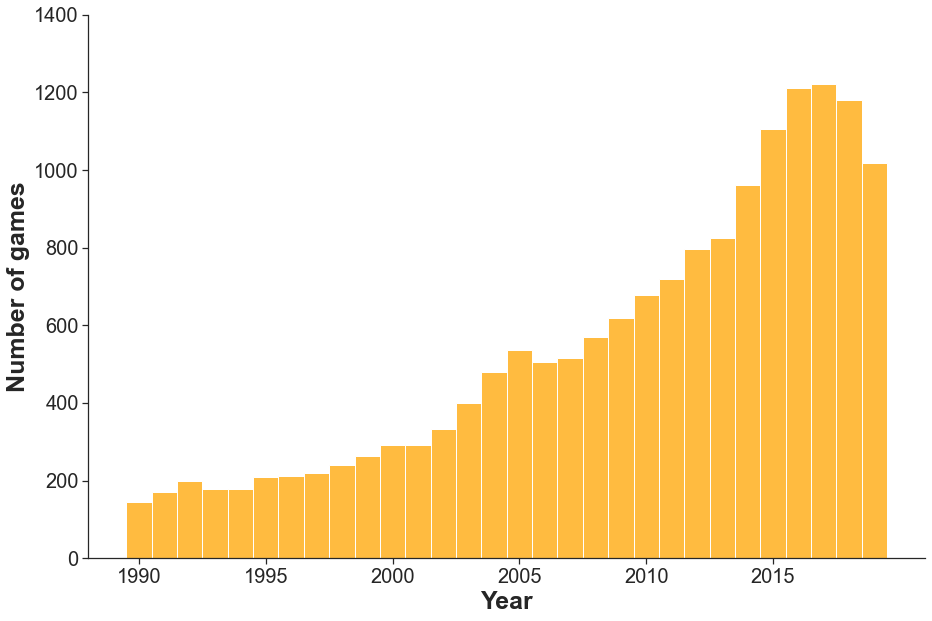

In [544]:
count_plot_over_year(games, 1990, 2019, False)

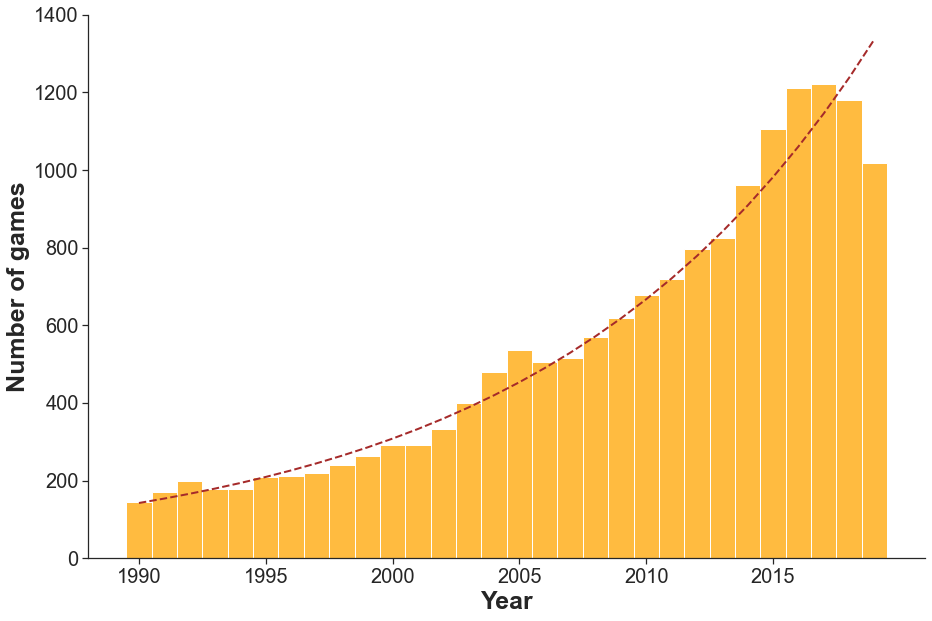

In [545]:
count_plot_over_year(games, 1990, 2019)

### 2. Average values of game attributes over years

In [6]:
games.columns

Index(['id', 'name', 'description', 'yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage',
       'category', 'mechanic', 'designer', 'publisher', 'numratings',
       'avgrating', 'bayesavgrating', 'rank', 'stdrating', 'medianrating',
       'numowned', 'numtrades', 'numwants', 'numwishes', 'numcomments',
       'numweights', 'averageweight', 'n_mechanics', 'n_categories'],
      dtype='object')

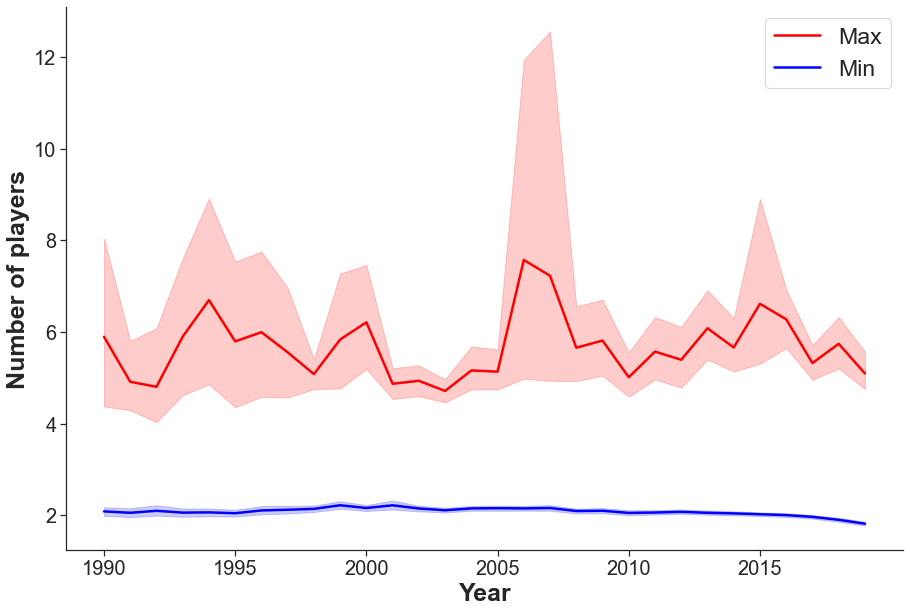

In [559]:
# TODO: set the thershold on the number of ratings?
lb = 1990; ub = 2019
df = games.loc[(games["yearpublished"] >= lb) & (games["yearpublished"] <= ub)]

fig = plt.figure(figsize=(15,10))
attribute_list = ["minplayers", "maxplayers"]

sns.lineplot(data=df, x="yearpublished", y=attribute_list[1], label="Max", color="red", linewidth=2.5)
p=sns.lineplot(data=df, x="yearpublished", y=attribute_list[0], label="Min", color="blue", linewidth=2.5)
plt.xlabel("Year", fontsize=25, weight="bold")
plt.ylabel("Number of players", fontsize=25, weight="bold")
plt.tick_params(labelsize=20)
plt.legend(fontsize=23)
p.set_xticks(p.get_xticks()[1:-2])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

In [30]:
df.columns

Index(['id', 'name', 'description', 'yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage',
       'category', 'mechanic', 'designer', 'publisher', 'numratings',
       'avgrating', 'bayesavgrating', 'rank', 'stdrating', 'medianrating',
       'numowned', 'numtrades', 'numwants', 'numwishes', 'numcomments',
       'numweights', 'averageweight', 'n_mechanics', 'n_categories'],
      dtype='object')

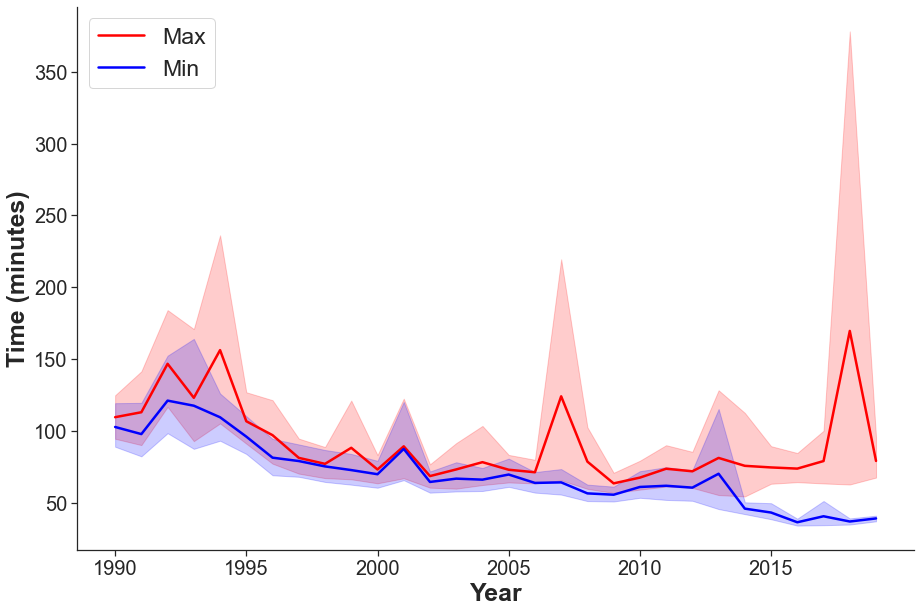

In [560]:
# TODO: set the thershold on the number of ratings?
lb = 1990; ub = 2019
df = games.loc[(games["yearpublished"] >= lb) & (games["yearpublished"] <= ub)]
#df = df.loc[games["numratings"] > 100]

fig = plt.figure(figsize=(15,10))
attribute_list = ["minplaytime", "maxplaytime"]

sns.lineplot(data=df, x="yearpublished", y=attribute_list[1], label="Max", color="red", linewidth=2.5)
p = sns.lineplot(data=df, x="yearpublished", y=attribute_list[0], label="Min", color="blue", linewidth=2.5)
plt.xlabel("Year", fontsize=25, weight="bold")
plt.ylabel("Time (minutes)", fontsize=25, weight="bold")
plt.tick_params(labelsize=20)
plt.legend(fontsize=23, loc="upper left")
p.set_xticks(p.get_xticks()[1:-2])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

In [552]:
df.loc[(df["yearpublished"] == 2018) & (df["maxplaytime"] > 300), ["name", "minplaytime", "maxplaytime", "numowned"]]

name  minplaytime  \
3921                       Cataclysm: A Second World War           90   
5089                                      Don't Get Got!           30   
7509                              At Any Cost: Metz 1870          120   
8494        The Dark Sands: War in North Africa, 1940-42           90   
8730        Battle Hymn Vol. 1: Gettysburg and Pea Ridge           45   
9725           Roads to Gettysburg II: Lee Strikes North           60   
9959                                 Thunder in the East          480   
10087  Königsberg: The Soviet Attack on East Prussia,...          240   
10822   Longstreet Attacks: The Second Day at Gettysburg           90   
11490                                               1828          210   
12066                                Nemesis: Burma 1944          360   
12633                            1985: Under an Iron Sky          120   
12779                                             1822CA          360   
14168                        SAGA Rulebook (2nd Edition)           40   
14590       Radetzky's March: The Hundred Hours Campaign           60   
15222                    Russia Besieged: Deluxe Edition          120   
15575                          Montélimar: Anvil of Fate          120   
15605                                  D-Day at Iwo Jima           90   
15790  Across The Narva: The Soviet Assault on Estoni...          480   
17667  Brezhnev's War: NATO vs. the Warsaw Pact in Ge...          240   
18570  Red Star/White Eagle: The Russo-Polish War, 19...          180   

       maxplaytime  numowned  
3921           600      1505  
5089          1440      1196  
7509           480       824  
8494          1500       796  
8730           480       461  
9725          1200       581  
9959           720       514  
10087          480       316  
10822          720       438  
11490          420        93  
12066          600       293  
12633       120000       298  
12779          540        69  
14168          320       131  
14590          360       155  
15222         1200       227  
15575         3000       260  
15605          360       307  
15790          600       180  
17667          360       121  
18570          480       210

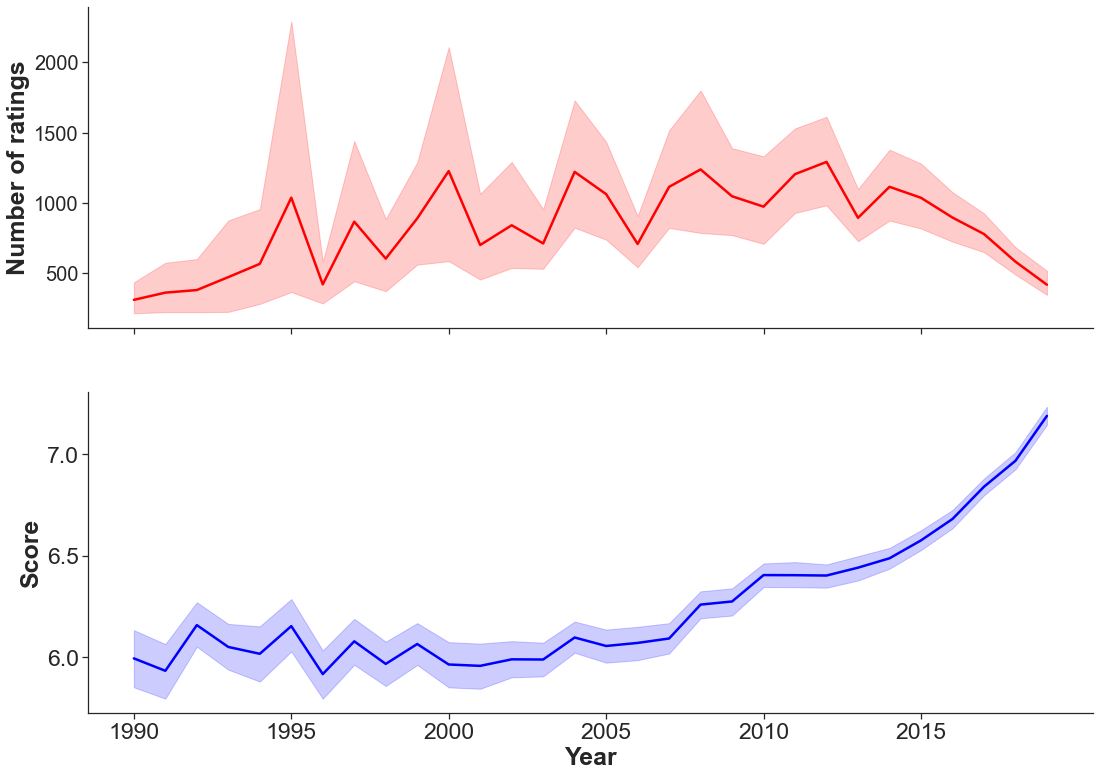

In [557]:
# TODO: set the thershold on the number of ratings?
lb = 1990; ub = 2019
df = games.loc[(games["yearpublished"] >= lb) & (games["yearpublished"] <= ub)]
attribute_list = ["numratings", "avgrating"]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(18,13))
p = sns.lineplot(data=df, x="yearpublished", y=attribute_list[0], ax=ax1, color="red", linewidth=2.5)
p.set_xlabel("Year", fontsize=25,weight="bold")
p.set_ylabel("Number of ratings", fontsize=25,weight="bold")
p.tick_params(labelsize=20)
#p.set_ylim([1.5,12.3])
p2 = sns.lineplot(data=df, x="yearpublished", y=attribute_list[1], ax=ax2, color="blue", linewidth=2.5)
p2.set_xlabel("Year", fontsize=25, weight="bold")
ax2.set_ylabel("Score", fontsize=25, weight="bold")
p2.tick_params(labelsize=23)

#p.set_xticks(p.get_xticks()[1:-2])
p2.set_xticks(p2.get_xticks()[1:-2])
#fig.suptitle("Trend of the averages of attributes from {} to {}".format(lb, ub), fontsize=20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

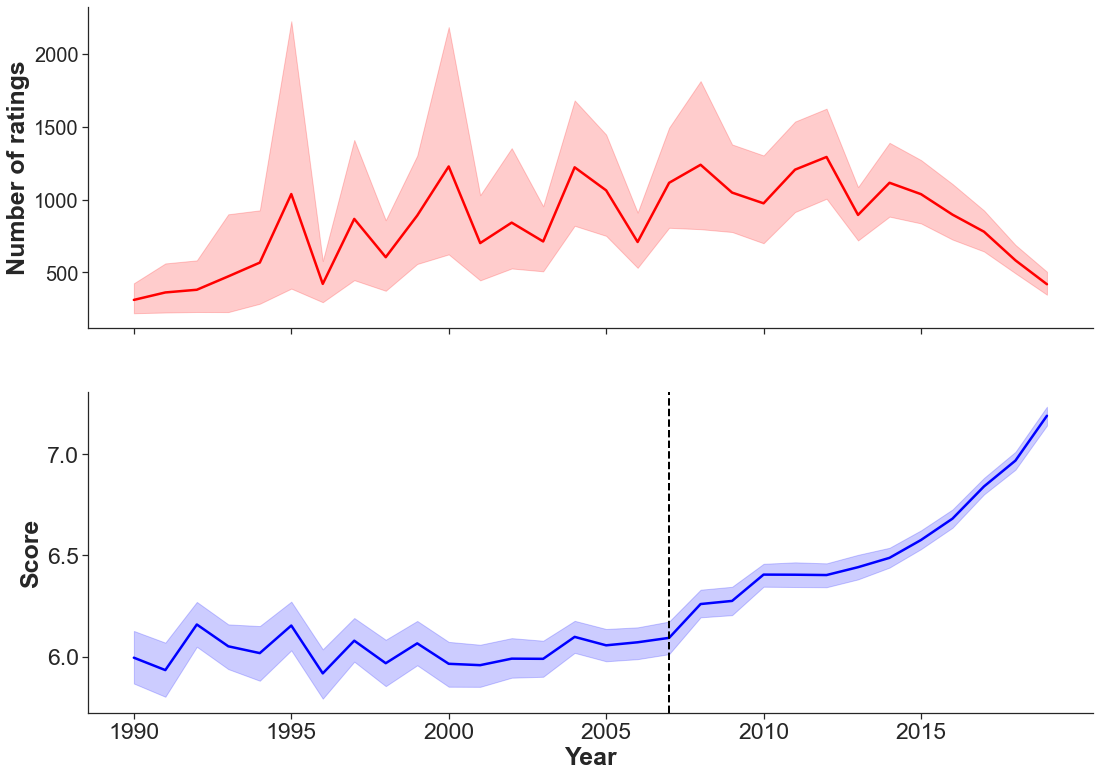

In [558]:
# TODO: set the thershold on the number of ratings?
lb = 1990; ub = 2019
df = games.loc[(games["yearpublished"] >= lb) & (games["yearpublished"] <= ub)]
attribute_list = ["numratings", "avgrating"]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(18,13))
p = sns.lineplot(data=df, x="yearpublished", y=attribute_list[0], ax=ax1, color="red", linewidth=2.5)
p.set_xlabel("Year", fontsize=25,weight="bold")
p.set_ylabel("Number of ratings", fontsize=25,weight="bold")
p.tick_params(labelsize=20)
p2 = sns.lineplot(data=df, x="yearpublished", y=attribute_list[1], ax=ax2, color="blue", linewidth=2.5)
p2.set_xlabel("Year", fontsize=25, weight="bold")
ax2.set_ylabel("Score", fontsize=25, weight="bold")
ax2.axvline(2007, linewidth=2, ls='--', color="black")
p2.tick_params(labelsize=23)
p2.set_xticks(p2.get_xticks()[1:-2])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

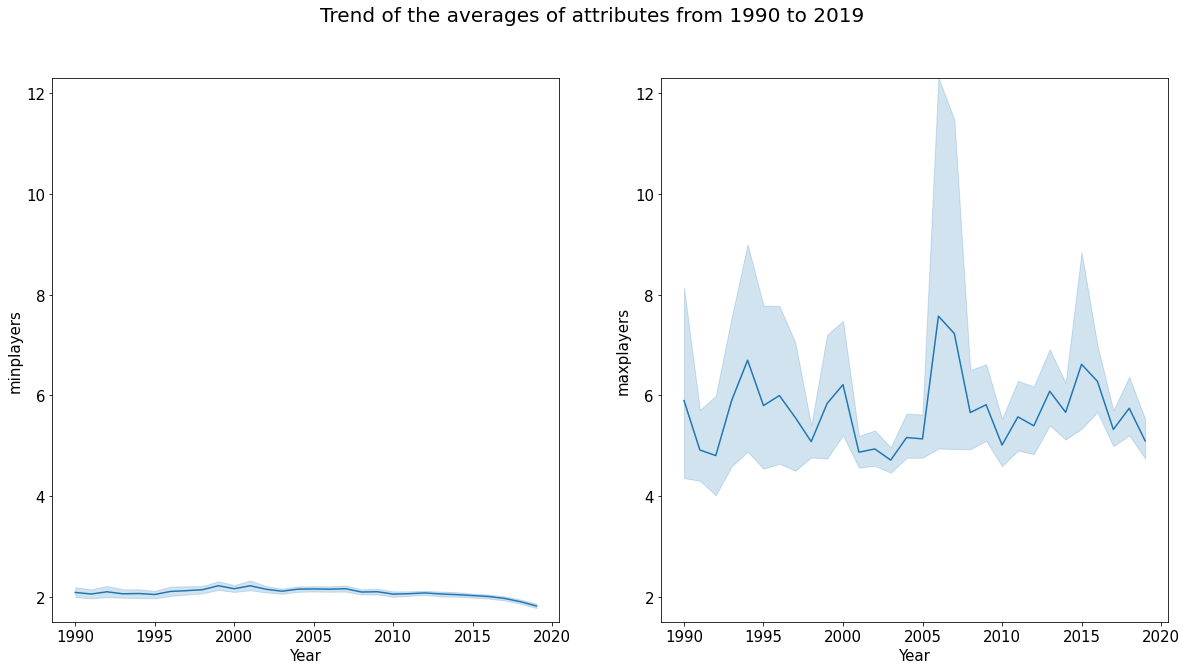

In [12]:
# TODO: set the thershold on the number of ratings?
lb = 1990; ub = 2019
df = games.loc[(games["yearpublished"] >= lb) & (games["yearpublished"] <= ub)]
#df = df.loc[games["numratings"] > 100]
#fig = plt.figure(figsize=(20,10))
attribute_list = ["numratings", "avgrating"]
#attribute_list = ["minplayers", "maxplayers",  "minage", "n_mechanics", 
#                  "numratings", "avgrating"]
                  #"n_categories", "playingtime"]
for i, attribute in enumerate(attribute_list):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    plt.subplot(1,2,i+1)
    p = sns.lineplot(data=df, x="yearpublished", y=attribute)
    p.set_xlabel("Year", fontsize=15)
    p.set_ylabel(attribute, fontsize=15)
    p.tick_params(labelsize=15)
    p.set_ylim([1.5,12.3])
fig.suptitle("Trend of the averages of attributes from {} to {}".format(lb, ub), fontsize=20)
plt.show()

In [28]:
df.columns

Index(['id', 'name', 'description', 'yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage',
       'category', 'mechanic', 'designer', 'publisher', 'numratings',
       'avgrating', 'bayesavgrating', 'rank', 'stdrating', 'medianrating',
       'numowned', 'numtrades', 'numwants', 'numwishes', 'numcomments',
       'numweights', 'averageweight', 'n_mechanics', 'n_categories'],
      dtype='object')

In [ ]:
# TODO: set the thershold on the number of ratings?
lb = 1990; ub = 2019
df = games.loc[(games["yearpublished"] >= lb) & (games["yearpublished"] <= ub)]
df = df.loc[games["numratings"] > 100]
fig = plt.figure(figsize=(20,20))
attribute_list = ["numratings", "avgrating"]
                  #"n_categories", "playingtime"]
for i, attribute in enumerate(attribute_list):
    plt.subplot(4,2,i+1)
    p = sns.lineplot(data=df, x="yearpublished", y=attribute)
    p.set_xlabel("Publisehd year", fontsize=15)
    p.set_ylabel(attribute, fontsize=15)
    p.tick_params(labelsize=15)
fig.suptitle("Trend of the averages of attributes from {} to {}".format(lb, ub), fontsize=20)
plt.show()

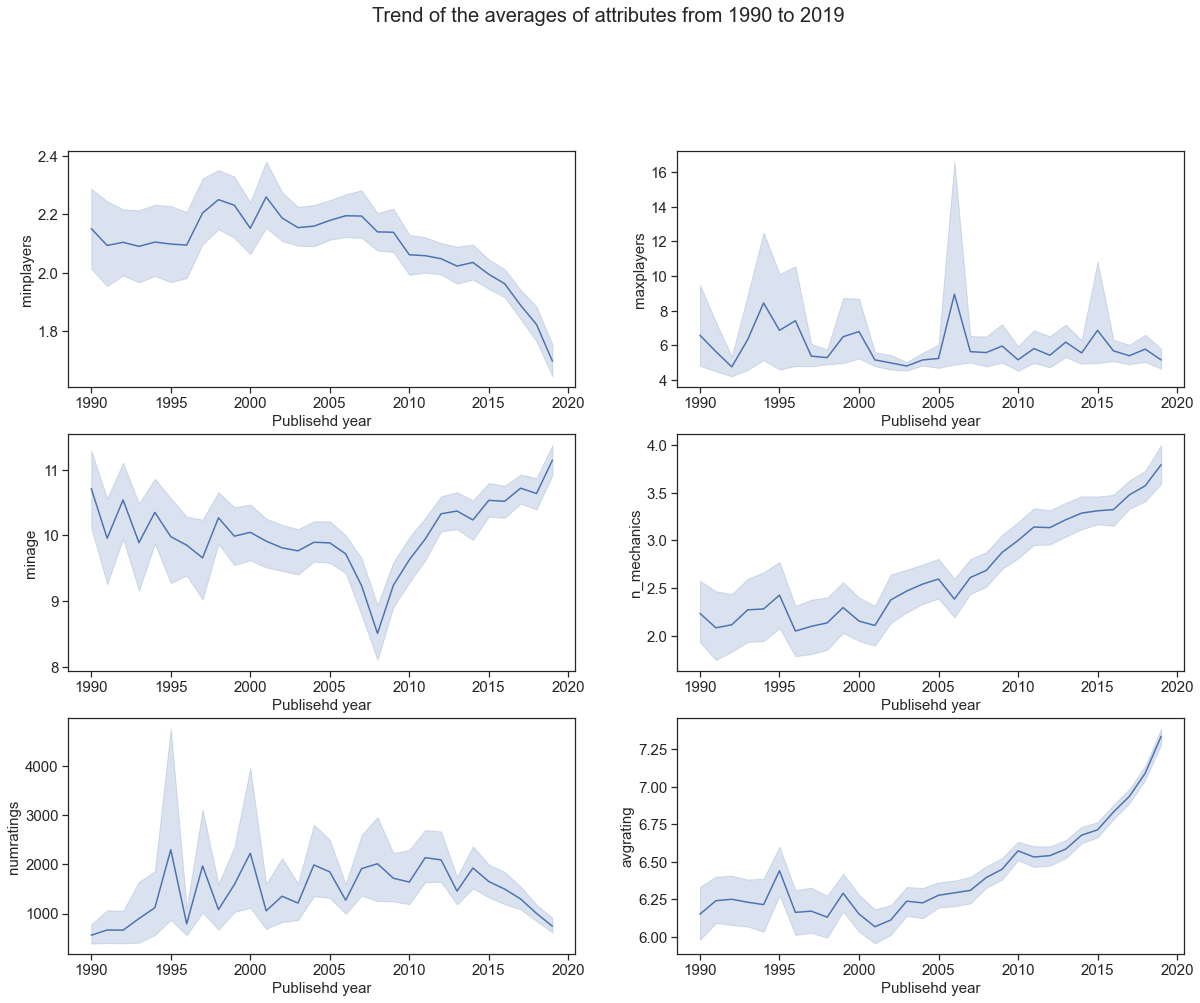

In [92]:
# TODO: set the thershold on the number of ratings?
lb = 1990; ub = 2019
df = games.loc[(games["yearpublished"] >= lb) & (games["yearpublished"] <= ub)]
df = df.loc[games["numratings"] > 100]
fig = plt.figure(figsize=(20,20))
attribute_list = ["minplayers", "maxplayers",  "minage", "n_mechanics", 
                  "numratings", "avgrating"]
                  #"n_categories", "playingtime"]
for i, attribute in enumerate(attribute_list):
    plt.subplot(4,2,i+1)
    p = sns.lineplot(data=df, x="yearpublished", y=attribute)
    p.set_xlabel("Publisehd year", fontsize=15)
    p.set_ylabel(attribute, fontsize=15)
    p.tick_params(labelsize=15)
fig.suptitle("Trend of the averages of attributes from {} to {}".format(lb, ub), fontsize=20)
plt.show()

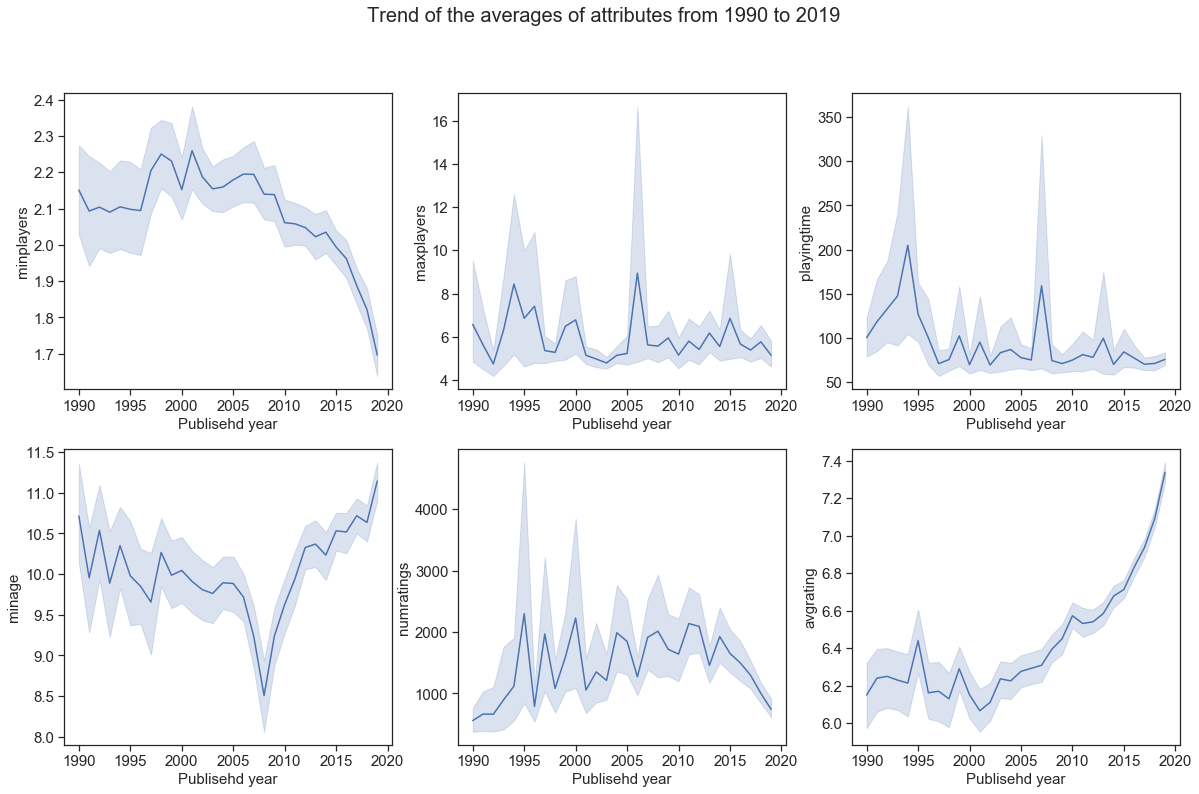

In [7]:
# TODO: set the thershold on the number of ratings?
lb = 1990; ub = 2019
df = games.loc[(games["yearpublished"] >= lb) & (games["yearpublished"] <= ub)]
df = df.loc[games["numratings"] > 100]
fig = plt.figure(figsize=(20,12))
attribute_list = ["minplayers", "maxplayers", "playingtime", "minage", "numratings", "avgrating"]
for i, attribute in enumerate(attribute_list):
    plt.subplot(2,3,i+1)
    p = sns.lineplot(data=df, x="yearpublished", y=attribute)
    p.set_xlabel("Publisehd year", fontsize=15)
    p.set_ylabel(attribute, fontsize=15)
    p.tick_params(labelsize=15)
fig.suptitle("Trend of the averages of attributes from {} to {}".format(lb, ub), fontsize=20)
plt.show()

2007/2008 seems like an outlier (eperimental period?)

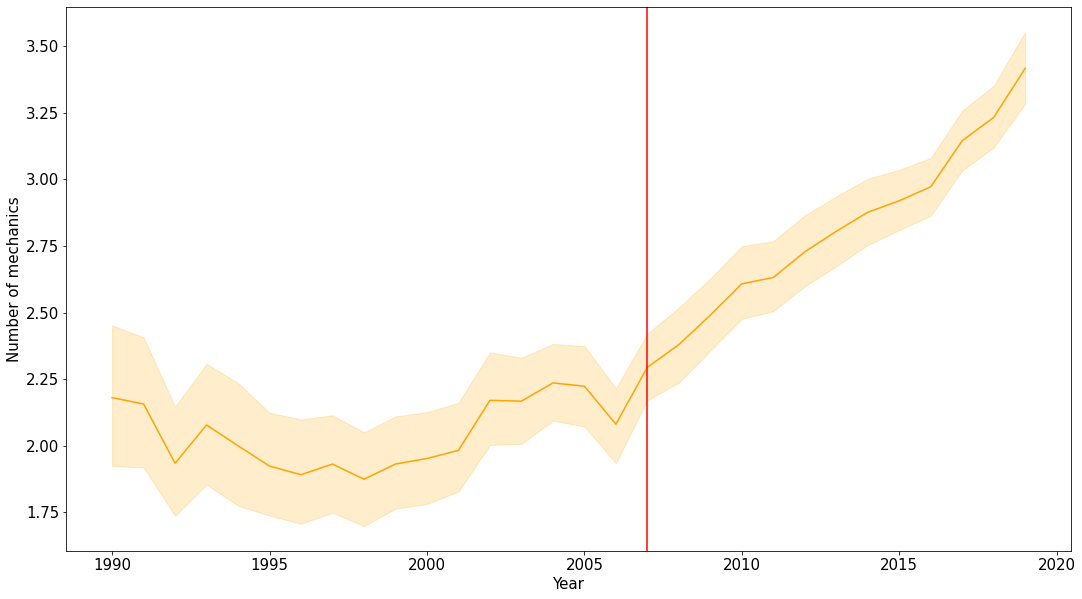

In [376]:
f=plt.figure(figsize=(18,10))
p = sns.lineplot(data=df, x="yearpublished", y="n_mechanics", color="orange")
p.set_xlabel("Year", fontsize=15)
p.set_ylabel("Number of mechanics", fontsize=15)
plt.axvline(x=2007, color="red")
p.tick_params(labelsize=15)

In [6]:
### TODO: Trend in the rate of published games per attribute?

In [ ]:
### Plot n_mechanics!!!

In [365]:
from word_cloud import *

In [366]:
import re

In [367]:
games.columns

Index(['id', 'name', 'description', 'yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage',
       'category', 'mechanic', 'designer', 'publisher', 'numratings',
       'avgrating', 'bayesavgrating', 'rank', 'stdrating', 'medianrating',
       'numowned', 'numtrades', 'numwants', 'numwishes', 'numcomments',
       'numweights', 'averageweight', 'n_mechanics', 'n_categories'],
      dtype='object')

In [368]:
def get_stop_words():
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.extend([c for c in punctuation] + ['quot', 'rsquo', 'mdash', 'ndash','s', 'game', "", 
                                                  "playing", "play", "player", "games", "rule", "players",
                                                 "rule","turn","card", "win", "cards", "boards", "board",
                                                 "first", "played", "must", "may", "rules"]
        + [str(x) for x in np.arange(100)] 
        + ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"]
        )
    return set(stop_words)

In [382]:
def generate_word_cloud(ds, max_words=200, width=500, height=500, background_color='white', title=""):
    '''Generate a word cloud from a pandas data series with text data'''
    assert isinstance(ds, pd.Series)

    stop_words = get_stop_words()
    tokenized_ds = ds.dropna().apply(nltk.word_tokenize)
    tokenized_ds = [ (re.sub(r'[^\w\s]','',x)).lower() for ls in tokenized_ds for x in ls ]
    words = [word for word in tokenized_ds if word not in stop_words]
    
    wc = WordCloud(background_color=background_color, max_words=max_words, width=width, height=height)
    wc.generate(' '.join(words))
    plt.imshow(wc)
    plt.axis('off')
    fig=plt.gcf()
    fig.set_size_inches(15,10)
    plt.title(title, fontsize=25, fontweight="bold", pad=20)
    plt.show()

In [370]:
ds1 = games.loc[games["yearpublished"] <= 2007, "description"]
ds2 = games.loc[games["yearpublished"] > 2007, "description"]

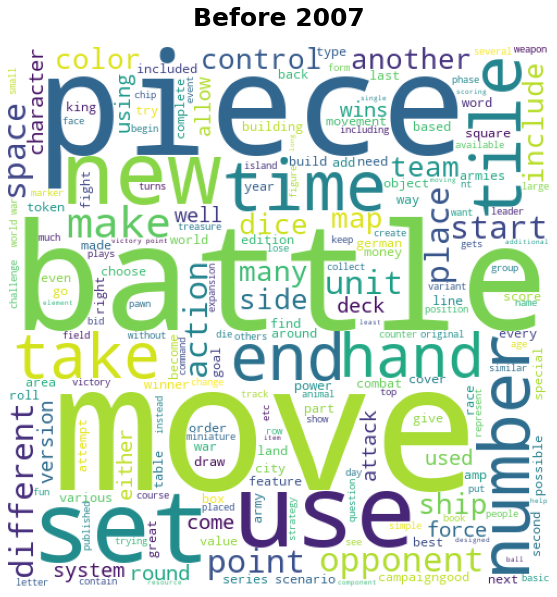

In [386]:
generate_word_cloud(ds1, title="Before 2007")

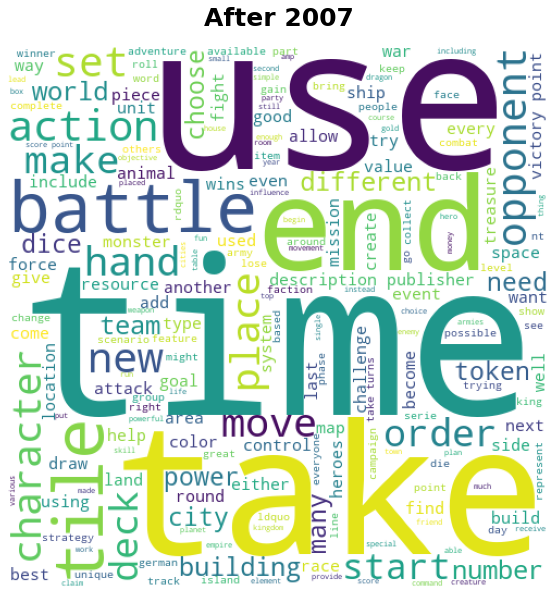

In [387]:
generate_word_cloud(ds2, title="After 2007")

In [ ]:
# mechanics_count = processing_columns(df['mechanic'])
# plot_word_cloud(mechanics_count)

In [571]:
# Read data
games = pd.read_csv("Data/games_detailed_info.csv", index_col=0) # review stats
# 1. Remove columns with > 20% of NA values 
key_columns = keep_columns_with_few_na(games)
# 2. Remove redundant/unnecesary columns
unnecessary_columns = ["type", "thumbnail", "image", "suggested_num_players", "suggested_playerage", 
                       "suggested_language_dependence"]
key_columns = [x for x in key_columns if x not in unnecessary_columns]
# 3. Rename confusing column names
games = games.loc[:,key_columns]
games.rename(columns={"primary": "name", "usersrated": "numratings", "average": "avgrating",
                      "boardgamecategory": "category", "boardgamemechanic": "mechanic", 
                      "boardgamedesigner": "designer", "boardgamepublisher": "publisher", 
                      "bayesaverage": "bayesavgrating", "Board Game Rank": "rank", 
                      "stddev": "stdrating", "median": "medianrating",
                      "owned": "numowned", "trading": "numtrades", "wanting":"numwants", 
                      "wishing": "numwishes"}, inplace=True)

In [572]:
games["category"] = games["category"].apply(lambda x: x[1:-1] if isinstance(x, str) else "")
games["mechanic"] = games["mechanic"].apply(lambda x: x[1:-1] if isinstance(x, str) else "")
games["designer"] = games["designer"].apply(lambda x: x[1:-1] if isinstance(x, str) else "")
games["publisher"] = games["publisher"].apply(lambda x: x[1:-1] if isinstance(x, str) else "")

In [508]:
df1 = games.loc[games["yearpublished"] < 2007]
df2 = games.loc[games["yearpublished"] >= 2007]

In [75]:
df1.columns

Index(['id', 'name', 'description', 'yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage',
       'category', 'mechanic', 'designer', 'publisher', 'numratings',
       'avgrating', 'bayesavgrating', 'rank', 'stdrating', 'medianrating',
       'numowned', 'numtrades', 'numwants', 'numwishes', 'numcomments',
       'numweights', 'averageweight'],
      dtype='object')

In [70]:
import collections

In [94]:
print(df1.shape[0])
print(df2.shape[0])

7501
11729


In [103]:
sum(mechanic_cnts1.values())

16690

In [91]:
mechanic_cnts1 = collections.Counter(itertools.chain.from_iterable([y.strip("'") for y in items.split(', ') if len(y)>0] for items in df1["mechanic"]))
mechanic_cnts2 = collections.Counter(itertools.chain.from_iterable([y.strip("'") for y in items.split(', ') if len(y)>0] for items in df2["mechanic"]))


In [567]:
[x.replace(" / ", "/") for x in xx_key]

['Take That',
 'Modular Board',
 'Tile Placement',
 'Cooperative Game',
 'Area Majority/Influence',
 'Card Drafting',
 'Set Collection',
 'Variable Player Powers',
 'Hand Management',
 'Dice Rolling']

In [ ]:
def plot_top_ten_tiems(games, colname, yearbp=2007):
    df1 = games.loc[games["yearpublished"] < yearbp]
    df2 = games.loc[games["yearpublished"] >= yearbp]
    
    item_cnts1 = collections.Counter(itertools.chain.from_iterable([y.strip("'") for y in items.split(', ') if len(y)>0] for items in df1[colname]))
    item_cnts2 = collections.Counter(itertools.chain.from_iterable([y.strip("'") for y in items.split(', ') if len(y)>0] for items in df2[colname]))

    # TODO: bar plot with labels
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,10))

    xx = item_cnts1.most_common(10)
    xx_key = [x[0] for x in xx][::-1] 
    xx_key = [x.replace(" / ", "/") for x in xx_key]
    xx_val = [100*x[1]/df1.shape[0] for x in xx][::-1] 

    ax1.barh(xx_key, xx_val, color="royalblue")
    ax1.set_xlim((0,40))
    ax1.set_xlabel("Share (%)", fontsize=18, weight="bold")
    ax1.yaxis.set_tick_params(labelsize=18)
    ax1.set_yticklabels(xx_key, weight="bold")
    ax1.set_title("Before {}".format(yearbp), fontsize=25, weight="bold", pad=20)
    for i, v in enumerate(xx_val):
        ax1.text(v + 0.5, i-0.1, str(round(v,1)), color='royalblue', fontweight='bold', fontsize=15)
    ax1.set_xticks([])


    xx = item_cnts2.most_common(10)
    xx_key = [x[0] for x in xx][::-1] 
    xx_key = [x.replace(" / ", "/") for x in xx_key]
    xx_val = [100*x[1]/df2.shape[0] for x in xx][::-1] 

    ax2.barh(xx_key, xx_val, color="salmon") #, c="red")
    ax2.set_xlim((0,40))
    ax2.set_xlabel("Share (%)", fontsize=18, weight="bold")
    ax2.yaxis.set_tick_params(labelsize=18)
    ax2.set_title("After {}".format(yearbp), fontsize=25, weight="bold", pad=20)
    ax2.set_xticks([])
    ax2.set_yticklabels(xx_key, weight="bold")
    ax2.yaxis.tick_right()
    ax2.invert_xaxis()
    for i, v in enumerate(xx_val):
        ax2.text((v + 2.5), i-0.1, str(round(v,1)), color='salmon', fontweight='bold', fontsize=15)

In [754]:
def plot_top_ten_tiems(games, colname, yearbp=2007 , colorfont=False):
    df1 = games.loc[games["yearpublished"] < yearbp]
    df2 = games.loc[games["yearpublished"] >= yearbp]
    
    item_cnts1 = collections.Counter(itertools.chain.from_iterable([y.strip("'").strip('"') for y in items.split(', ') if len(y)>0 and "Card Game" not in y ] for items in df1[colname]))
    item_cnts2 = collections.Counter(itertools.chain.from_iterable([y.strip("'").strip('"') for y in items.split(', ') if len(y)>0 and "Card Game" not in y] for items in df2[colname]))

    # TODO: bar plot with labels
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4.5))

    xx = item_cnts1.most_common(10)
    xx_key = [x[0] for x in xx][::-1] 
    xx_key = [x.replace(" / ", "/") for x in xx_key]
    xx_val = [100*x[1]/df1.shape[0] for x in xx][::-1] 

    ax1.barh(xx_key, xx_val, color="royalblue")
    ax1.set_xlim((0,32))
    ax1.set_xlabel("Share (%)", fontsize=18, weight="bold")
    ax1.yaxis.set_tick_params(labelsize=18)
    ax1.set_yticklabels(xx_key, weight="bold")
    ax1.set_title("Before {}".format(yearbp), fontsize=25, weight="bold", pad=20)
    for i, v in enumerate(xx_val):
        ax1.text(v + 0.5, i-0.1, str(round(v,1)), color='royalblue', fontweight='bold', fontsize=15)
    ax1.set_xticks([])
    
    xx_val1 = xx_val
    inters = xx_key

    xx = item_cnts2.most_common(10)
    xx_key = [x[0] for x in xx][::-1] 
    xx_key = [x.replace(" / ", "/") for x in xx_key]
    xx_val = [100*x[1]/df2.shape[0] for x in xx][::-1] 

    ax2.barh(xx_key, xx_val, color="salmon") #, c="red")
    ax2.set_xlim((0,32))
    ax2.set_xlabel("Share (%)", fontsize=18, weight="bold")
    ax2.yaxis.set_tick_params(labelsize=18)
    ax2.set_title("After {}".format(yearbp), fontsize=25, weight="bold", pad=20)
    ax2.set_xticks([])
    ax2.set_yticklabels(xx_key, weight="bold")
    ax2.yaxis.tick_right()
    ax2.invert_xaxis()
    for i, v in enumerate(xx_val):
        if i >= 7:
            ax2.text((v + 3.1), i-0.1, str(round(v,1)), color='salmon', fontweight='bold', fontsize=15)
        else:
            ax2.text((v + 2.2), i-0.1, str(round(v,1)), color='salmon', fontweight='bold', fontsize=15)
        
    inters = [x for x in inters if x in xx_key]
    print(inters)
    
    if colorfont:
        colors1 = ["royalblue" if x.get_text() not in inters else "black" for x in ax1.get_yticklabels()]
        [t.set_color(i) for (i,t) in
         zip(colors1, 
             ax1.get_yticklabels())]
        
        colors2 = ["salmon" if x.get_text() not in inters else "black" for x in ax2.get_yticklabels()]
        [t.set_color(i) for (i,t) in
         zip(colors2, 
             ax2.get_yticklabels())]
    plt.tight_layout()
    return(df1, df2, item_cnts1, item_cnts2, inters)

['Fighting', 'Science Fiction', 'Economic', 'Party Game', 'Fantasy', 'Wargame']


/Users/yeinkim/miniconda2/envs/ece143-project/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/yeinkim/miniconda2/envs/ece143-project/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


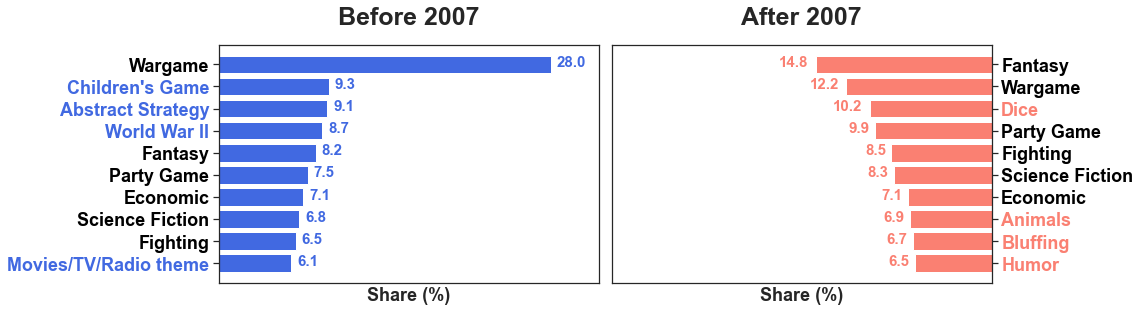

In [755]:
df1, df2, item_cnts1, item_cnts2, inters = plot_top_ten_tiems(games, "category", yearbp=2007, colorfont=True)

['Fighting', 'Science Fiction', 'Economic', 'Party Game', 'Fantasy', 'Wargame']


/Users/yeinkim/miniconda2/envs/ece143-project/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/yeinkim/miniconda2/envs/ece143-project/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


(          id                           name  \
 1        822                    Carcassonne   
 2         13                          Catan   
 5       9209                 Ticket to Ride   
 8       3076                    Puerto Rico   
 12     14996         Ticket to Ride: Europe   
 ...      ...                            ...   
 19214  22990                     Les Aigles   
 19217  21001  Alibi Saknas: Herrgårdsmordet   
 19218  19531                     Charoodles   
 19223  13154      Monopoly: Popular Edition   
 19224  28371     Monopoly: My Marvel Heroes   
 
                                              description  yearpublished  \
 1      Carcassonne is a tile-placement game in which ...           2000   
 2      In Catan (formerly The Settlers of Catan), pla...           1995   
 5      With elegantly simple gameplay, Ticket to Ride...           2004   
 8      In Puerto Rico players assume the roles of col...           2002   
 12     Ticket to Ride: Europe takes you o

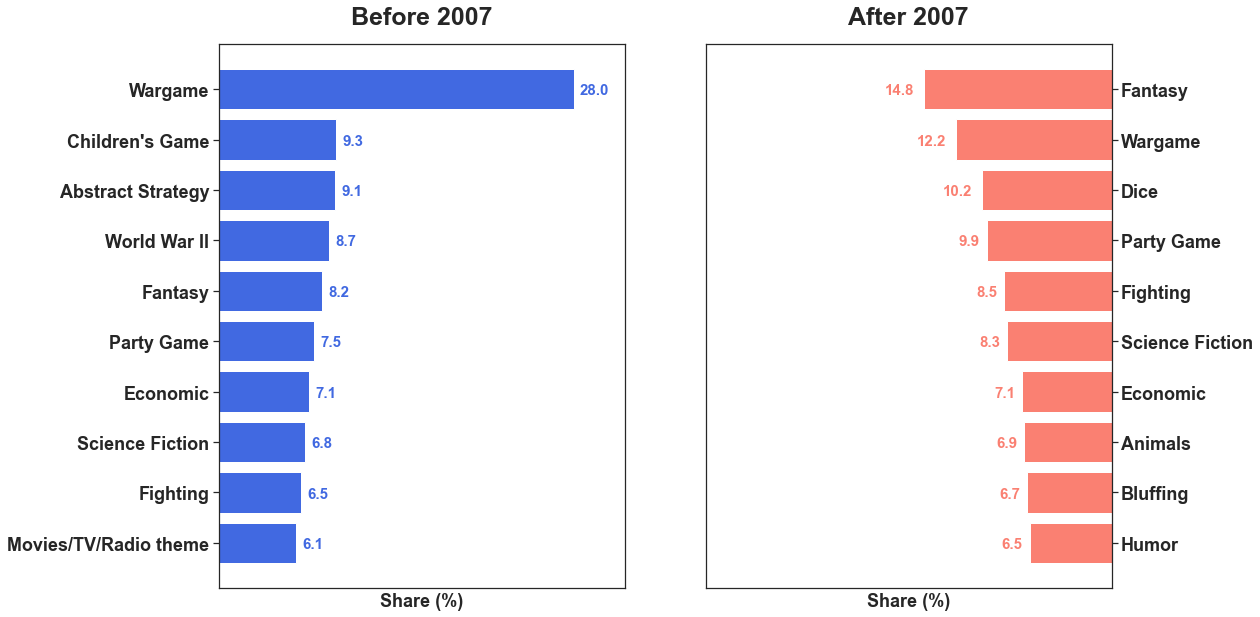

In [694]:
plot_top_ten_tiems(games, "category", yearbp=2007)

In [697]:
inters

['Fighting', 'Science Fiction', 'Economic', 'Party Game', 'Fantasy', 'Wargame']

In [ ]:
#inters = ["Fantasy", "Wargame", "Party Game", "Fighting", "Science Fiction", "Economic"]
inters = [  'Economic', 'Science Fiction', 'Fighting', 'Party Game', 'Fantasy', 'Wargame']
plt.figure(figsize=(10,5))
d1 = [100*item_cnts1[k]/df1.shape[0] for k in inters]
d2 = [100*item_cnts2[k]/df2.shape[0] for k in inters]
plt.scatter(d1, list(inters), c="royalblue", s=110, label="Before 2007")#, alpha=0.7)
plt.scatter(d2, list(inters), c="salmon", s=110, label="After 2007")#, alpha=0.7)
plt.scatter(d1[0], "Economic", c="purple", s=110)
#plt.scatter(d2, list(inters), c="salmon", s=110, label="After 2007")#, alpha=0.7)
plt.xlabel("Share (%)", fontsize=18, weight="bold")
plt.xticks(fontsize=15) #, weight="bold")
plt.yticks(fontsize=15, weight="bold")
for i in np.arange(len(inters)-1):
    if abs(d2[i]-d1[i]) > 0.5:
        plt.arrow(d1[i]+0.3, i, (d2[i]-d1[i])-0.8, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015, color="black" )#, color="purple")
i = len(inters)-1
plt.arrow(d1[i]-0.3, i, (d2[i]-d1[i])+0.85, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015, color="black" )#, color="purple")
plt.legend(loc="lower right", fontsize=15)


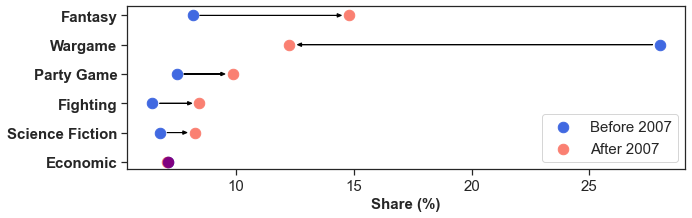

In [761]:
#inters = ["Fantasy", "Wargame", "Party Game", "Fighting", "Science Fiction", "Economic"]
inters = [  'Economic', 'Science Fiction', 'Fighting', 'Party Game', 'Wargame', 'Fantasy']
plt.figure(figsize=(10,3))
d1 = [100*item_cnts1[k]/df1.shape[0] for k in inters]
d2 = [100*item_cnts2[k]/df2.shape[0] for k in inters]
plt.scatter(d1, list(inters), c="royalblue", s=110, label="Before 2007")#, alpha=0.7)
plt.scatter(d2, list(inters), c="salmon", s=110, label="After 2007")#, alpha=0.7)
plt.scatter(d1[0], "Economic", c="purple", s=110)
#plt.scatter(d2, list(inters), c="salmon", s=110, label="After 2007")#, alpha=0.7)
plt.xlabel("Share (%)", fontsize=15, weight="bold")
plt.xticks(fontsize=15) #, weight="bold")
plt.yticks(fontsize=15, weight="bold")
for i in np.arange(len(inters)):
    if abs(d2[i]-d1[i]) > 0.5:
        if i != len(inters)-2:
            plt.arrow(d1[i]+0.3, i, (d2[i]-d1[i])-0.8, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015, color="black" )#, color="purple")
i = len(inters)-2
plt.arrow(d1[i]-0.3, i, (d2[i]-d1[i])+0.85, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015, color="black" )#, color="purple")
plt.legend(loc="lower right", fontsize=15)


/Users/yeinkim/miniconda2/envs/ece143-project/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/yeinkim/miniconda2/envs/ece143-project/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


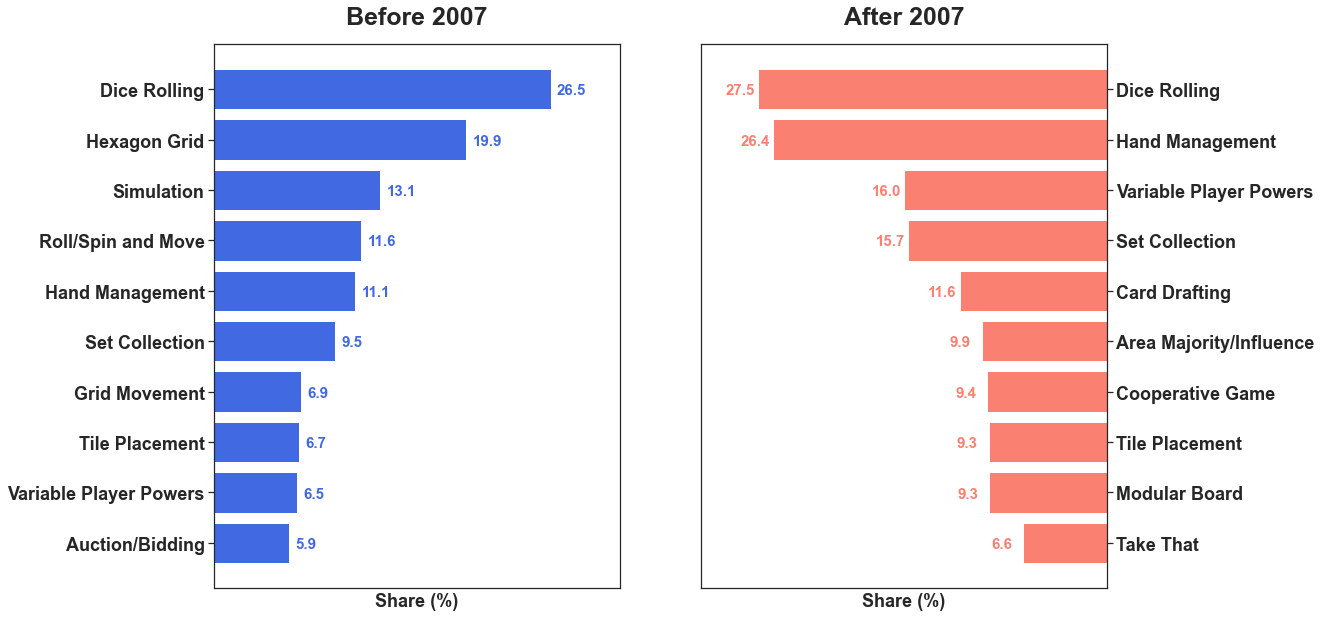

In [576]:
plot_top_ten_tiems(games, "mechanic", yearbp=2007)

/Users/yeinkim/miniconda2/envs/ece143-project/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/yeinkim/miniconda2/envs/ece143-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


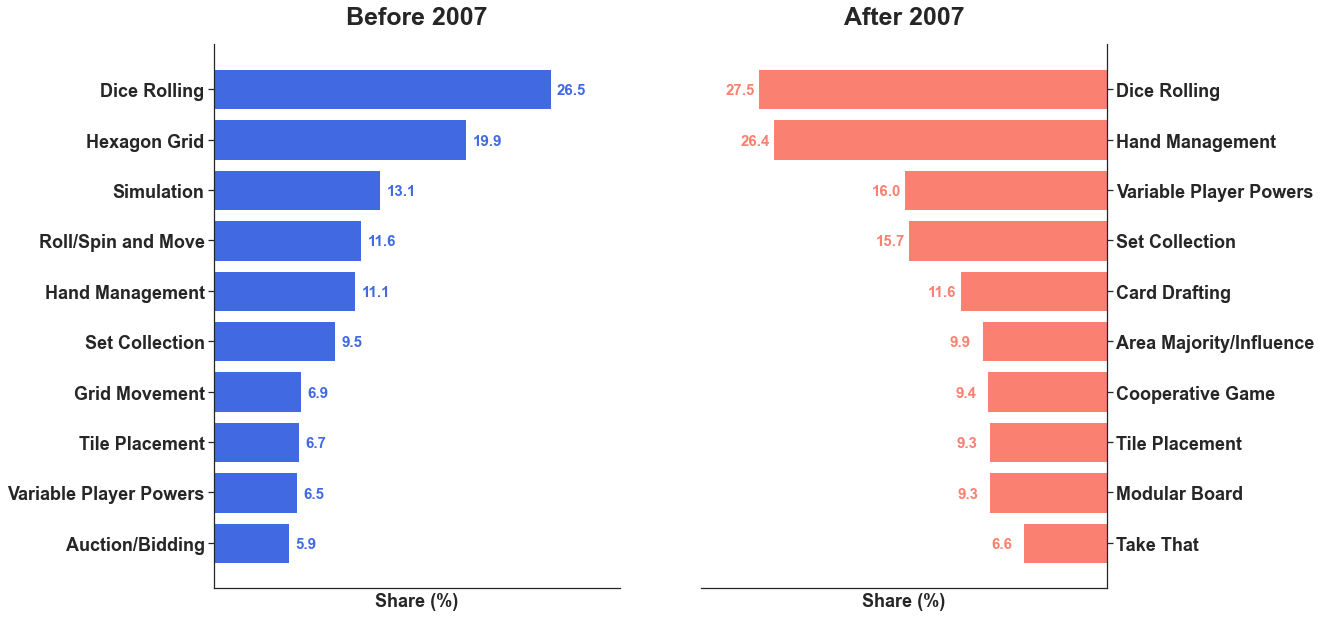

In [564]:
# TODO: bar plot with labels
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,10))

xx = mechanic_cnts1.most_common(10)
xx_key = [x[0] for x in xx][::-1] 
xx_val = [100*x[1]/df1.shape[0] for x in xx][::-1] 
xx_key[-4] = "Roll/Spin and Move"


ax1.barh(xx_key, xx_val, color="royalblue") #, c="red")
ax1.set_xlim((0,32))
ax1.set_xlabel("Share (%)", fontsize=18, weight="bold")
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_yticklabels(xx_key, weight="bold")
ax1.set_title("Before 2007", fontsize=25, weight="bold", pad=20)
for i, v in enumerate(xx_val):
    ax1.text(v + 0.5, i-0.1, str(round(v,1)), color='royalblue', fontweight='bold', fontsize=15)
ax1.set_xticks([])


xx = mechanic_cnts2.most_common(10)
xx_key = [x[0] for x in xx][::-1] 
xx_val = [100*x[1]/df2.shape[0] for x in xx][::-1] 
xx_key[-6] = "Area Majority/Influence"

ax2.barh(xx_key, xx_val, color="salmon") #, c="red")
ax2.set_xlim((0,32))
ax2.set_xlabel("Share (%)", fontsize=18, weight="bold")
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_title("After 2007", fontsize=25, weight="bold", pad=20)
ax2.set_xticks([])
ax2.set_yticklabels(xx_key, weight="bold")
ax2.yaxis.tick_right()
ax2.invert_xaxis()
for i, v in enumerate(xx_val):
    ax2.text((v + 2.5), i-0.1, str(round(v,1)), color='salmon', fontweight='bold', fontsize=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

In [528]:
before = [x[0] for x in mechanic_cnts1.most_common(10)]
after = [x[0] for x in mechanic_cnts2.most_common(10)]
inters = set(before).intersection(set(after))

In [529]:
inters

{'Dice Rolling',
 'Hand Management',
 'Set Collection',
 'Tile Placement',
 'Variable Player Powers'}

/Users/yeinkim/miniconda2/envs/ece143-project/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/yeinkim/miniconda2/envs/ece143-project/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


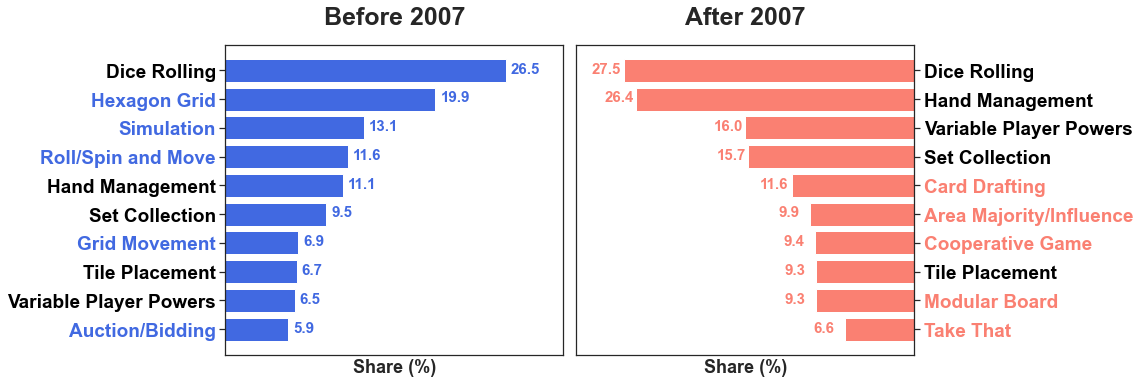

In [713]:
# TODO: bar plot with labels
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5.5))

xx = mechanic_cnts1.most_common(10)
xx_key = [x[0] for x in xx][::-1] 
xx_val = [100*x[1]/df1.shape[0] for x in xx][::-1] 
xx_key[-4] = "Roll/Spin and Move"


ax1.barh(xx_key, xx_val, color="royalblue") #, c="red")
ax1.set_xlim((0,32))
ax1.set_xlabel("Share (%)", fontsize=18, weight="bold")
ax1.yaxis.set_tick_params(labelsize=19)
ax1.set_yticklabels(xx_key, weight="bold")
ax1.set_title("Before 2007", fontsize=25, weight="bold", pad=20)
for i, v in enumerate(xx_val):
    ax1.text(v + 0.5, i-0.1, str(round(v,1)), color='royalblue', fontweight='bold', fontsize=15)
ax1.set_xticks([])
#[t.set_color(i) for (i,t) in
#  zip(['royalblue','purple','purple','royalblue','purple','purple','royalblue','royalblue','royalblue','purple'], 
#      ax1.get_yticklabels())]
[t.set_color(i) for (i,t) in
 zip(['royalblue','black','black','royalblue','black','black','royalblue','royalblue','royalblue','black'], 
     ax1.get_yticklabels())]


xx = mechanic_cnts2.most_common(10)
xx_key = [x[0] for x in xx][::-1] 
xx_val = [100*x[1]/df2.shape[0] for x in xx][::-1] 
xx_key[-6] = "Area Majority/Influence"

ax2.barh(xx_key, xx_val, color="salmon") #, c="red")
ax2.set_xlim((0,32))
ax2.set_xlabel("Share (%)", fontsize=18, weight="bold")
ax2.yaxis.set_tick_params(labelsize=19)
ax2.set_title("After 2007", fontsize=25, weight="bold", pad=20)
ax2.set_xticks([])
ax2.set_yticklabels(xx_key, weight="bold")
ax2.yaxis.tick_right()
ax2.invert_xaxis()
for i, v in enumerate(xx_val):
    ax2.text((v + 3), i-0.1, str(round(v,1)), color='salmon', fontweight='bold', fontsize=15)
#    ax2.text(v*1.2, i-0.1, str(round(v,1)), color='salmon', fontweight='bold', fontsize=15)
[t.set_color(i) for (i,t) in
 zip(['salmon','salmon','black','salmon','salmon','salmon','black','black','black','black'], 
     ax2.get_yticklabels())]

plt.tight_layout()

['Dice Rolling',
 'Hand Management',
 'Variable Player Powers',
 'Set Collection',
 'Tile Placement']

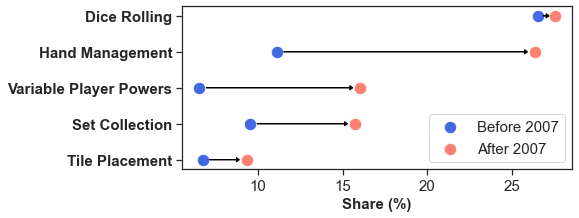

In [763]:
inters = [x[0] for x in mechanic_cnts2.most_common(10) if x[0] in [y[0] for y in mechanic_cnts1.most_common(10)]]
inters = [   'Tile Placement','Set Collection',"Variable Player Powers", "Hand Management", 'Dice Rolling']

plt.figure(figsize=(7,3))
d1 = [100*mechanic_cnts1[k]/df1.shape[0] for k in inters]
d2 = [100*mechanic_cnts2[k]/df2.shape[0] for k in inters]
plt.scatter(d1, list(inters), c="royalblue", s=110, label="Before 2007")
plt.scatter(d2, list(inters), c="salmon", s=110, label="After 2007")
plt.xlabel("Share (%)", fontsize=15, weight="bold")
plt.xticks(fontsize=15) #, weight="bold")
plt.yticks(fontsize=15, weight="bold")
for i in np.arange(len(inters)-1):
    plt.arrow(d1[i]+0.4, i, (d2[i]-d1[i])-1, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015, color="black" )#, color="purple")
i = len(inters)-1
plt.arrow(d1[i]+0.3, i, (d2[i]-d1[i])-0.8, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015, color="black" )#, color="purple")
plt.legend(loc="lower right", fontsize=15)
#plt.legend(fontsize=15)

In [721]:
inters

['Economic', 'Science Fiction', 'Fighting', 'Party Game', 'Fantasy', 'Wargame']

In [ ]:
#inters = ["Fantasy", "Wargame", "Party Game", "Fighting", "Science Fiction", "Economic"]
inters = [  'Economic', 'Science Fiction', 'Fighting', 'Party Game', 'Fantasy', 'Wargame']
plt.figure(figsize=(10,5))
d1 = [100*mechanic_cnts1[k]/df1.shape[0] for k in inters]
d2 = [100*mechanic_cnts2[k]/df2.shape[0] for k in inters]
plt.scatter(d1, list(inters), c="royalblue", s=110, label="Before 2007")#, alpha=0.7)
plt.scatter(d2, list(inters), c="salmon", s=110, label="After 2007")#, alpha=0.7)
plt.scatter(d1[0], "Economic", c="purple", s=110)
#plt.scatter(d2, list(inters), c="salmon", s=110, label="After 2007")#, alpha=0.7)
plt.xlabel("Share (%)", fontsize=18, weight="bold")
plt.xticks(fontsize=15) #, weight="bold")
plt.yticks(fontsize=15, weight="bold")
for i in np.arange(len(inters)-1):
    if abs(d2[i]-d1[i]) > 0.5:
        plt.arrow(d1[i]+0.3, i, (d2[i]-d1[i])-0.8, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015, color="black" )#, color="purple")
i = len(inters)-1
plt.arrow(d1[i]-0.3, i, (d2[i]-d1[i])+0.85, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015, color="black" )#, color="purple")
plt.legend(loc="lower right", fontsize=15)


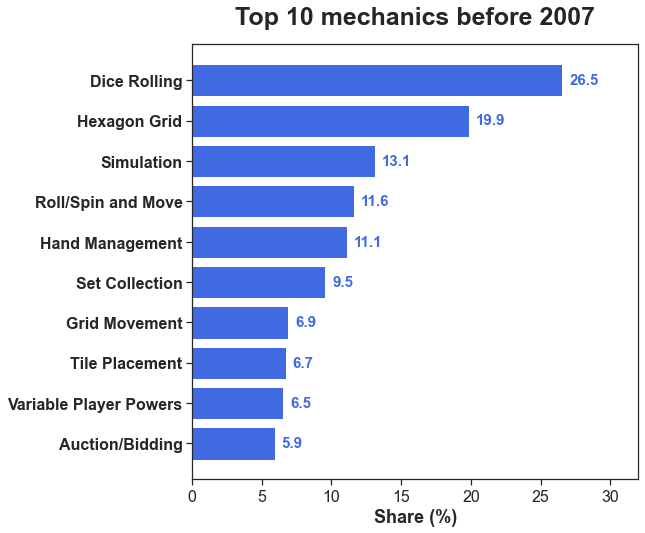

In [474]:
# TODO: bar plot with labels
xx = mechanic_cnts1.most_common(10)
xx_key = [x[0] for x in xx][::-1] 
xx_val = [100*x[1]/df1.shape[0] for x in xx][::-1] 
xx_key[-4] = "Roll/Spin and Move"
plt.figure(figsize=(8,8))
plt.barh(xx_key, xx_val, color="royalblue") #, c="red")
plt.xlim((0,32))
plt.xlabel("Share (%)", fontsize=18, weight="bold")
plt.yticks(fontsize=16, weight="bold")
plt.xticks(fontsize=16) #, weight="bold")
plt.title("Top 10 mechanics before 2007", fontsize=25, weight="bold", pad=20)
for i, v in enumerate(xx_val):
    plt.text(v + 0.5, i-0.1, str(round(v,1)), color='royalblue', fontweight='bold', fontsize=15)

Text(0.5, 1.0, 'Top 10 mechanics after 2007')

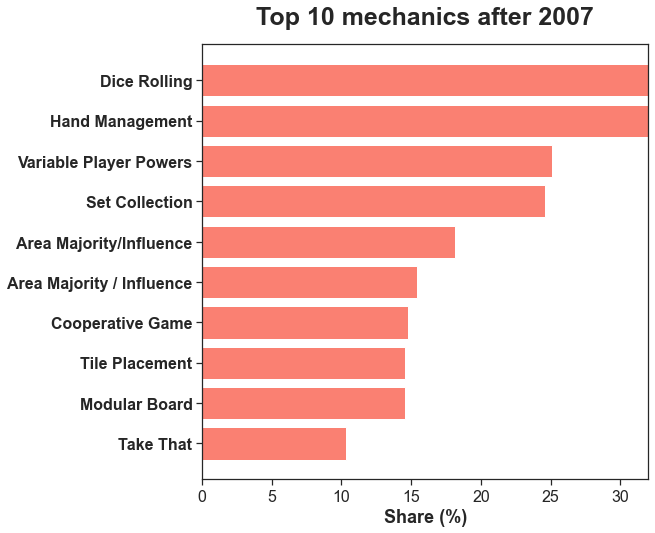

In [482]:
# TODO: bar plot with labels
xx = mechanic_cnts2.most_common(10)
xx_key = [x[0] for x in xx][::-1] 
xx_val = [100*x[1]/df1.shape[0] for x in xx][::-1] 
xx_key[-5] = "Area Majority/Influence"
plt.figure(figsize=(8,8))
plt.barh(xx_key, xx_val, color="salmon") #, c="red")
plt.xlim((0,32))
plt.xlabel("Share (%)", fontsize=18, weight="bold")
plt.yticks(fontsize=16, weight="bold")
plt.xticks(fontsize=16) #, weight="bold")
plt.title("Top 10 mechanics after 2007", fontsize=25, weight="bold", pad=20)
# for i, v in enumerate(xx_val):
#     plt.text(v + 0.5, i-0.1, str(round(v,1)), color='royalblue', fontweight='bold', fontsize=15)

In [476]:
# TODO: bar plot with labels
xx = mechanic_cnts2.most_common(10)
xx_key1 = [x[0] for x in xx][::-1] 
xx_val1 = [100*x[1]/df2.shape[0] for x in xx][::-1] 

#plt.figure(figsize=(8,8))
plt.barh(xx_key1, xx_val1, color="salmon") #, c="red")
plt.xlim((0,32))
plt.xlabel("Share (%)", fontsize=18, weight="bold")
plt.yticks(fontsize=16, weight="bold")
#[t.set_color(i) for (i,t) in
# zip(['black','black','royalblue','black','black','royalblue','royalblue','black','royalblue','royalblue'], plt.gca().get_yticklabels())]
#[i.set_color("red") for i in plt.gca().get_xticklabels()]
plt.xticks(fontsize=16) #, weight="bold")
plt.title("Top 10 mechanics after 2007", fontsize=25, weight="bold", pad=20)
for i, v in enumerate(xx_val1):
    plt.text(v + 0.5, i-0.1, str(round(v,1)), color='salmon', fontweight='bold', fontsize=15)

ValueError: Image size of 112880x316 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [477]:
# TODO: bar plot with labels
xx = mechanic_cnts2.most_common(10)
xx_key1 = [x[0] for x in xx][::-1] 
xx_val1 = [100*x[1]/df2.shape[0] for x in xx][::-1] 

plt.figure(figsize=(8,8))
plt.barh(xx_key1, xx_val1, color="salmon") #, c="red")
plt.xlim((0,32))
plt.xlabel("Share (%)", fontsize=18, weight="bold")
plt.yticks(fontsize=16, weight="bold")
[t.set_color(i) for (i,t) in
 zip(['black','black','royalblue','black','black','royalblue','royalblue','black','royalblue','royalblue'], plt.gca().get_yticklabels())]
#[i.set_color("red") for i in plt.gca().get_xticklabels()]
plt.xticks(fontsize=16) #, weight="bold")
plt.title("Top 10 mechanics after 2007", fontsize=25, weight="bold", pad=20)
for i, v in enumerate(xx_val1):
    plt.text(v + 0.5, i-0.1, str(round(v,1)), color='salmon', fontweight='bold', fontsize=15)

ValueError: Image size of 150419x533 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 576x576 with 1 Axes>

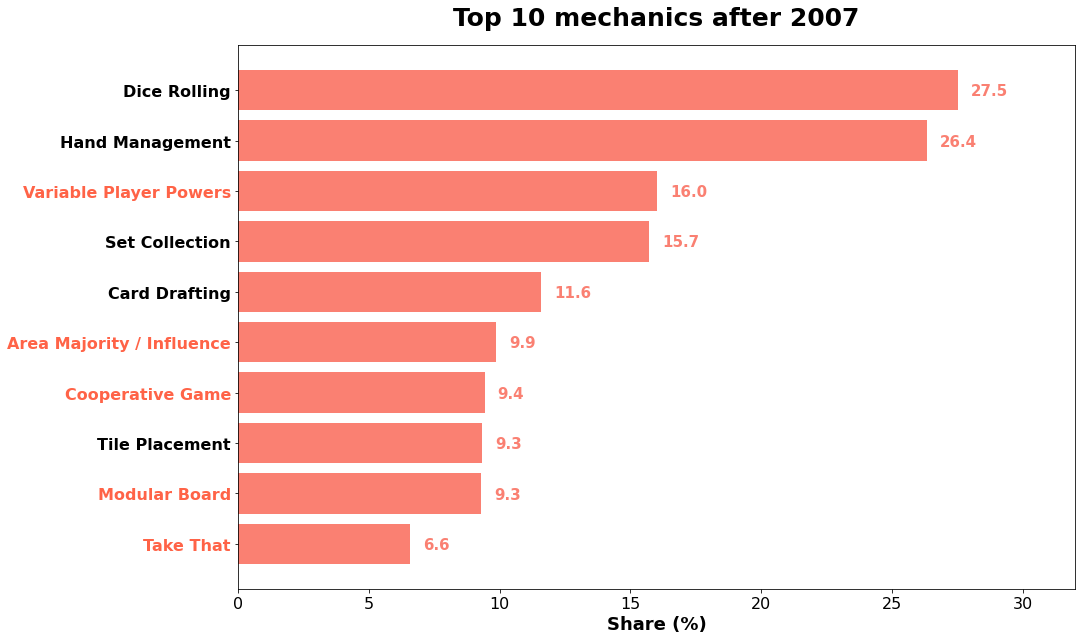

In [289]:
# TODO: bar plot with labels
xx = mechanic_cnts2.most_common(10)
xx_key1 = [x[0] for x in xx][::-1] 
xx_val1 = [100*x[1]/df2.shape[0] for x in xx][::-1] 

plt.figure(figsize=(15,10))
plt.barh(xx_key1, xx_val1, color="salmon") #, c="red")
plt.xlim((0,32))
plt.xlabel("Share (%)", fontsize=18, weight="bold")
plt.yticks(fontsize=16, weight="bold")
[t.set_color(i) for (i,t) in
 zip(['tomato','tomato','black','tomato','tomato','black','black','tomato','black','black'], plt.gca().get_yticklabels())]
#[i.set_color("red") for i in plt.gca().get_xticklabels()]
plt.xticks(fontsize=16) #, weight="bold")
plt.title("Top 10 mechanics after 2007", fontsize=25, weight="bold", pad=20)
for i, v in enumerate(xx_val1):
    plt.text(v + 0.5, i-0.1, str(round(v,1)), color='salmon', fontweight='bold', fontsize=15)

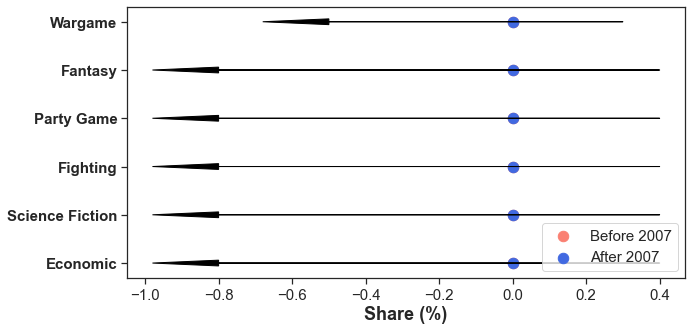

In [717]:
plt.figure(figsize=(10,5))
d1 = [100*mechanic_cnts1[k]/df1.shape[0] for k in inters]
d2 = [100*mechanic_cnts2[k]/df2.shape[0] for k in inters]
plt.scatter(d1, list(inters), c="salmon", s=110, label="Before 2007")
plt.scatter(d2, list(inters), c="royalblue", s=110, label="After 2007")
plt.xlabel("Share (%)", fontsize=18, weight="bold")
plt.xticks(fontsize=15) #, weight="bold")
plt.yticks(fontsize=15, weight="bold")
for i in np.arange(len(inters)-1):
    plt.arrow(d1[i]+0.4, i, (d2[i]-d1[i])-1.2, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015, color="black" )#, color="purple")
i = len(inters)-1
plt.arrow(d1[i]+0.3, i, (d2[i]-d1[i])-0.8, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015, color="black" )#, color="purple")
plt.legend(loc="lower right", fontsize=15)


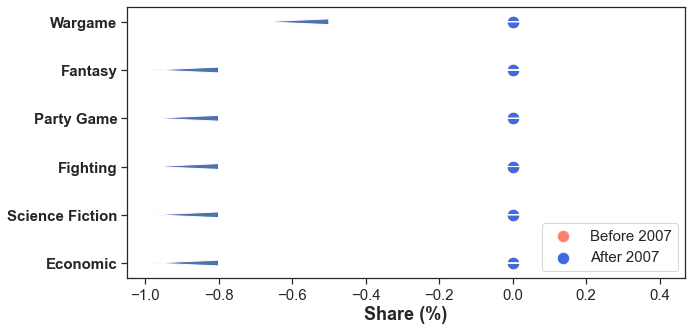

In [715]:
plt.figure(figsize=(10,5))
d1 = [100*mechanic_cnts1[k]/df1.shape[0] for k in inters]
d2 = [100*mechanic_cnts2[k]/df2.shape[0] for k in inters]
plt.scatter(d1, list(inters), c="salmon", s=110, label="Before 2007")
plt.scatter(d2, list(inters), c="royalblue", s=110, label="After 2007")
plt.xlabel("Share (%)", fontsize=18, weight="bold")
plt.xticks(fontsize=15) #, weight="bold")
plt.yticks(fontsize=15, weight="bold")
for i in np.arange(len(inters)-1):
    plt.arrow(d1[i]+0.4, i, (d2[i]-d1[i])-1.2, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015 )#, color="purple")
i = len(inters)-1
plt.arrow(d1[i]+0.3, i, (d2[i]-d1[i])-0.8, 0, head_starts_at_zero=False, head_width=0.12,width=0.0015 )#, color="purple")
plt.legend(loc="lower right", fontsize=15)


In [288]:
inters

{'Dice Rolling',
 'Hand Management',
 'Set Collection',
 'Tile Placement',
 'Variable Player Powers'}

In [ ]:
# TODO: bar plot with labels
xx = mechanic_cnts2.most_common(10)
xx_key1 = [x[0] for x in xx][::-1] 
xx_val1 = [100*x[1]/df2.shape[0] for x in xx][::-1] 

plt.figure(figsize=(15,10))
plt.barh(xx_key1, xx_val1, color="salmon") #, c="red")
plt.xlim((0,32))
plt.xlabel("Share (%)", fontsize=18, weight="bold")
plt.yticks(fontsize=16, weight="bold")
plt.xticks(fontsize=16) #, weight="bold")
plt.title("Top 10 mechanics after 2007", fontsize=25, weight="bold", pad=20)
for i, v in enumerate(xx_val1):
    plt.text(v + 0.5, i-0.1, str(round(v,1)), color='salmon', fontweight='bold', fontsize=15)

(0.0, 32.0)

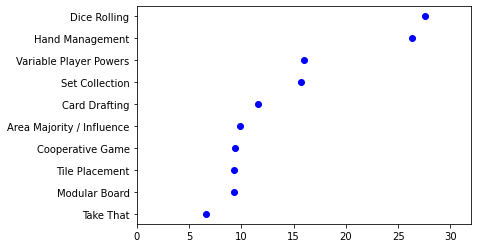

In [183]:
xx1 = mechanic_cnts2.most_common(10)
xx_key1 = [x[0] for x in xx1][::-1] 
xx_val1 = [100*x[1]/df2.shape[0] for x in xx1][::-1] 
plt.scatter(xx_val1, xx_key1, c="blue")
plt.xlim((0,32))

In [186]:
inters = set(xx_key).intersection(set(xx_key1))

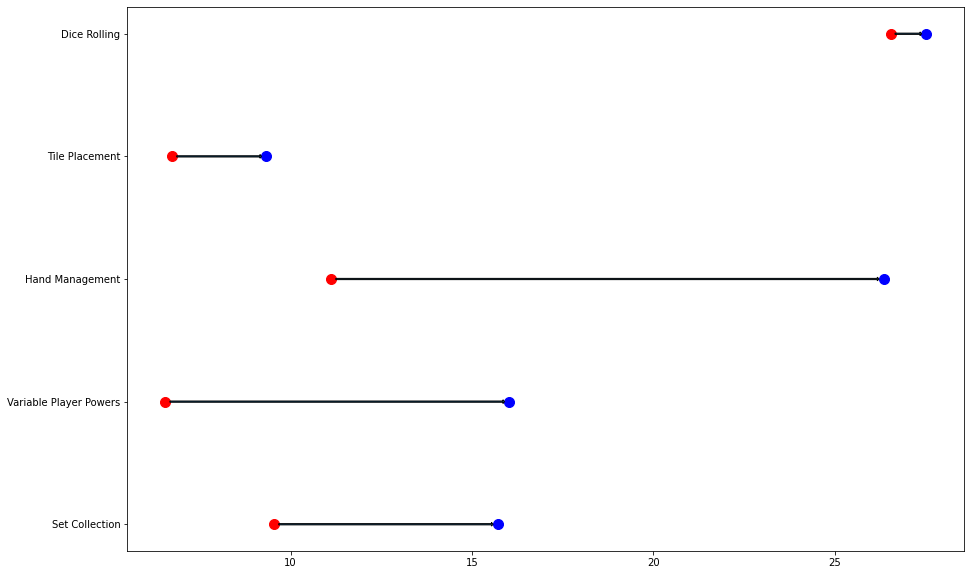

In [234]:
plt.figure(figsize=(15,10))
d1 = [100*mechanic_cnts1[k]/df1.shape[0] for k in inters]
d2 = [100*mechanic_cnts2[k]/df2.shape[0] for k in inters]
plt.scatter(d1, list(inters), c="red", s=100)
plt.scatter(d2, list(inters), c="blue", s=100)
for i in np.arange(len(inters)):
    plt.arrow(d1[i]+0.1, i, (d2[i]-d1[i])-0.3, 0, head_starts_at_zero=True, width=0.01 )#, color="purple")

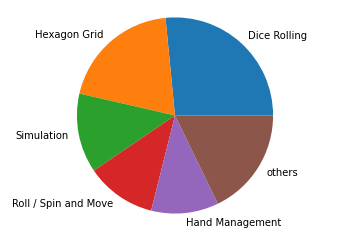

In [117]:


fig1, ax1 = plt.subplots()
ax1.pie(xx_val, labels=xx_key) #autopct='%1.1f%%'
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

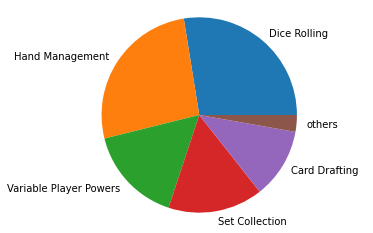

In [118]:
xx = mechanic_cnts2.most_common(5)
xx_key = [x[0] for x in xx] + ["Others"]
xx_val = [x[1] for x in xx]
xx_val.append(df2.shape[0]- sum(xx_val))

fig1, ax1 = plt.subplots()
ax1.pie(xx_val, labels=xx_key) #autopct='%1.1f%%'
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [120]:
mechanic_cnts1.most_common(10)

[('Dice Rolling', 1991),
 ('Hexagon Grid', 1490),
 ('Simulation', 982),
 ('Roll / Spin and Move', 869),
 ('Hand Management', 834),
 ('Set Collection', 716),
 ('Grid Movement', 516),
 ('Tile Placement', 505),
 ('Variable Player Powers', 491),
 ('Auction/Bidding', 445)]

In [93]:
mechanic_cnts2.most_common(10)

[('Dice Rolling', 3229),
 ('Hand Management', 3091),
 ('Variable Player Powers', 1880),
 ('Set Collection', 1843),
 ('Card Drafting', 1361),
 ('Area Majority / Influence', 1159),
 ('Cooperative Game', 1106),
 ('Tile Placement', 1094),
 ('Modular Board', 1090),
 ('Take That', 773)]

### 3. Trend in the rate of published games per attribute

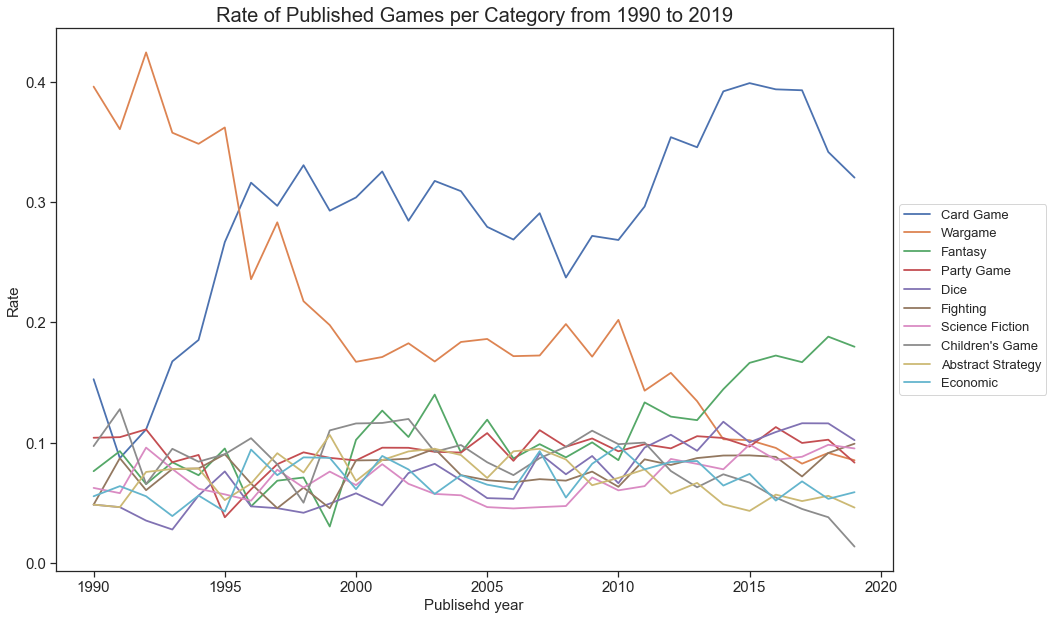

In [9]:
categories = [x[0] for x in category_cnt[:10]]
grouped_count_plot_over_year(games_category, 1990, 2019, categories, "Category")

Visible decline in war games while incrasing trend in card game/fantasy

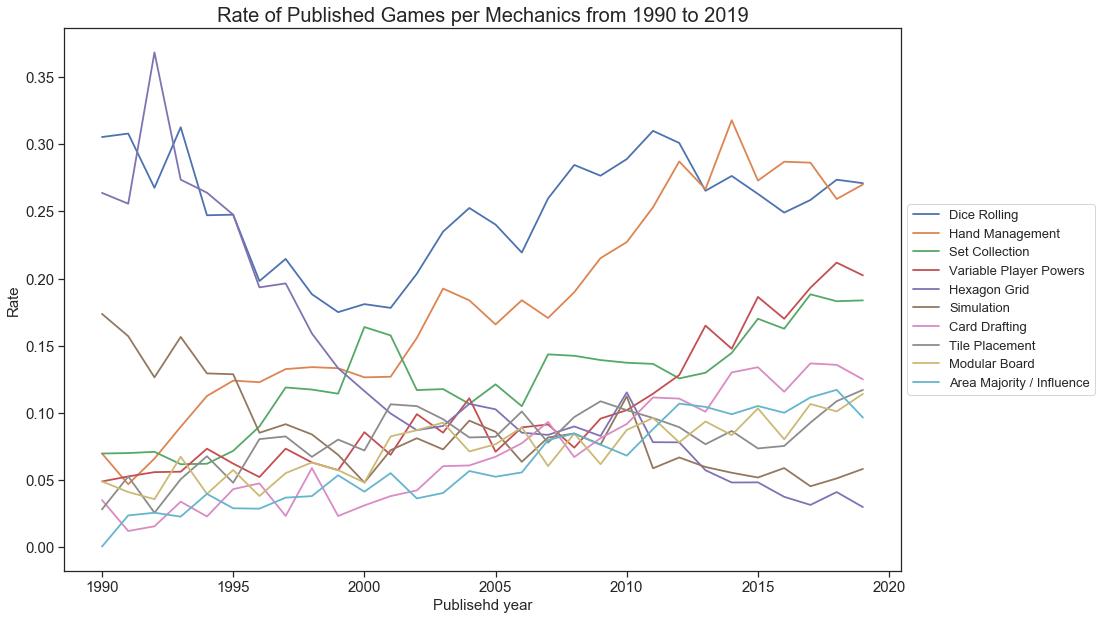

In [10]:
mechanics = [x[0] for x in mechanic_cnt[:10]]
grouped_count_plot_over_year(games_mechanic, 1990, 2019, mechanics, "Mechanics")

Declining trend in Hexaagon grid, increasing trend in hand management/variable player powers/set collections 

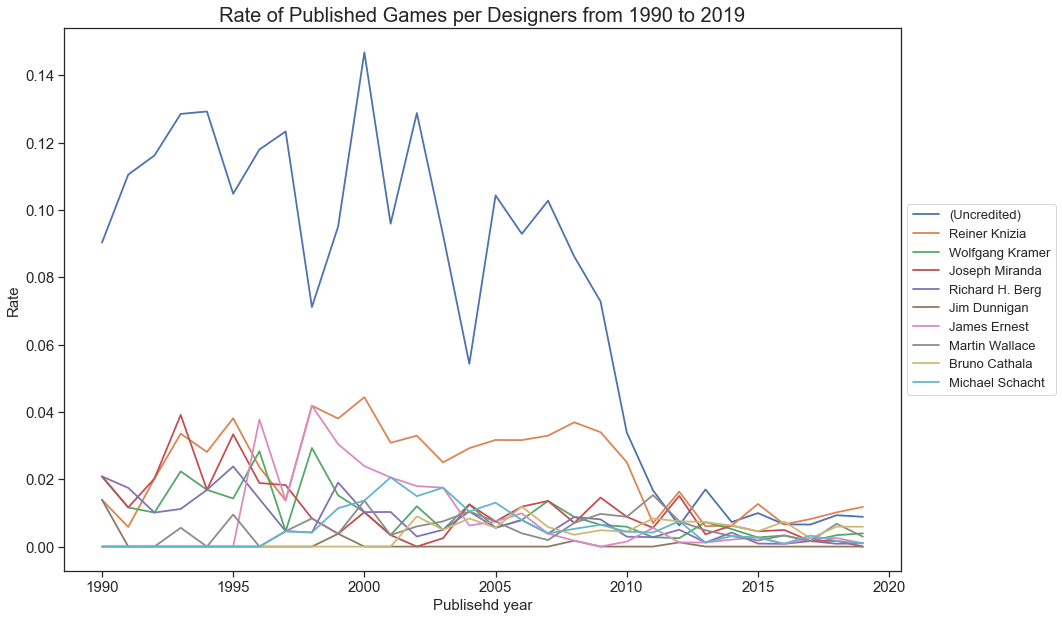

In [11]:
designers = [x[0] for x in designer_cnt[:10]]
grouped_count_plot_over_year(games_designer, 1990, 2019, designers, "Designers")

A lot of games were uncredited until 2010's. 

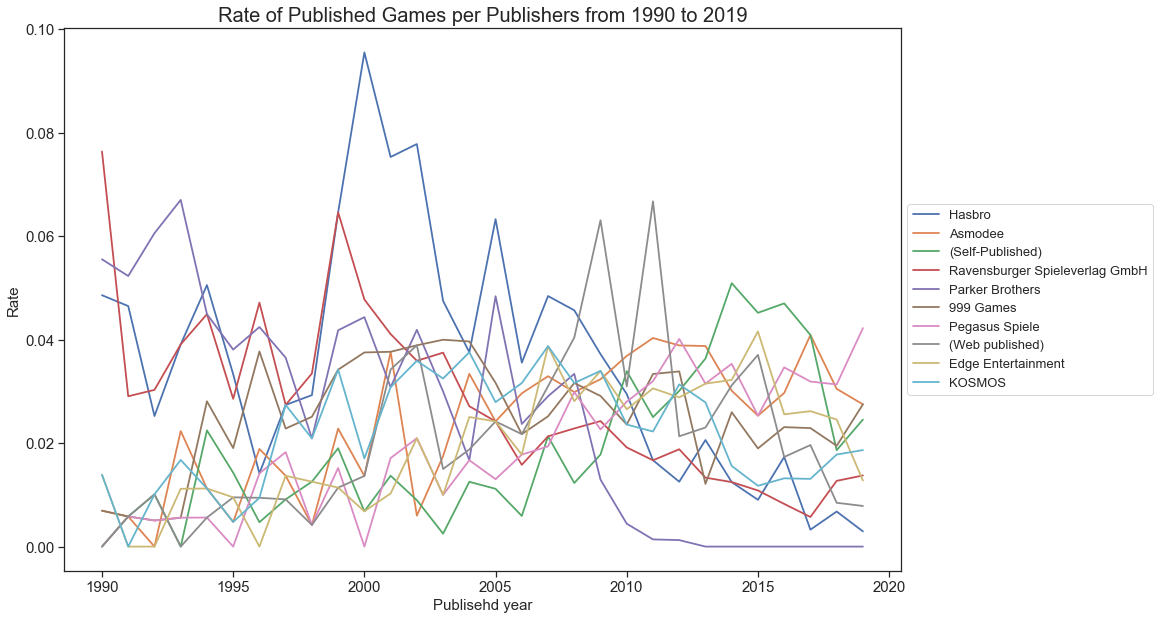

In [12]:
publishers = [x[0] for x in publisher_cnt[:10]]
grouped_count_plot_over_year(games_publisher, 1990, 2019, publishers, "Publishers")

No clear-cut dominace of a publisher; Hasbro's share peaked in early 2020's and then declined afterwards.

## Ratings per attribute

### Note: Filtered out games with num ratings < 100

In [13]:
popularity_metrics = ["avgrating", "numratings", 'numowned', 'numtrades', 'numwants', 'numwishes', 'numcomments']

### 1. Average popularity metrics per category

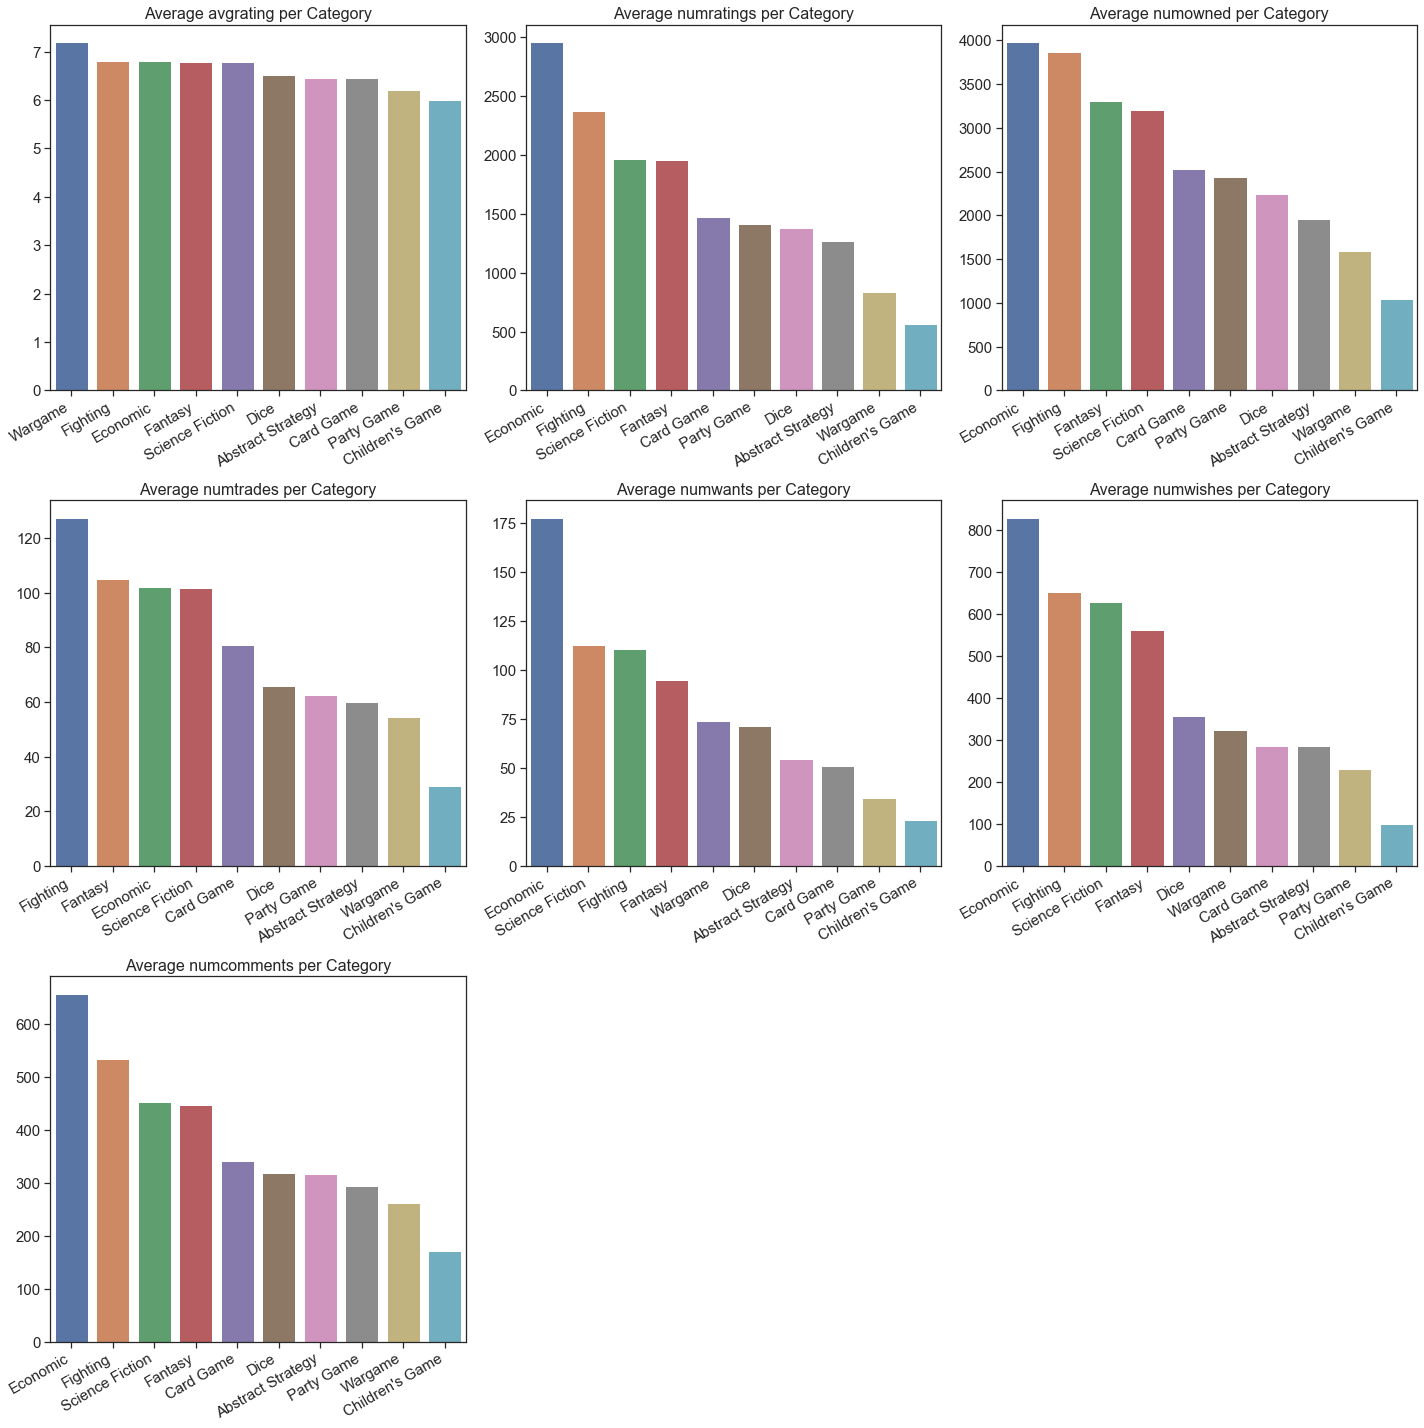

In [14]:
splits, overallstats = summarize_per_attribute(games_category, 100, 1990, 2019, categories, popularity_metrics)
fig = plt.figure(figsize=(20,20))
for i, metric in enumerate(popularity_metrics):
    plt.subplot(3,3,i+1)
    plot_avg_stats(overallstats, metric, "Category")
plt.tight_layout()

### 2. Average popularity metrics per mechanics

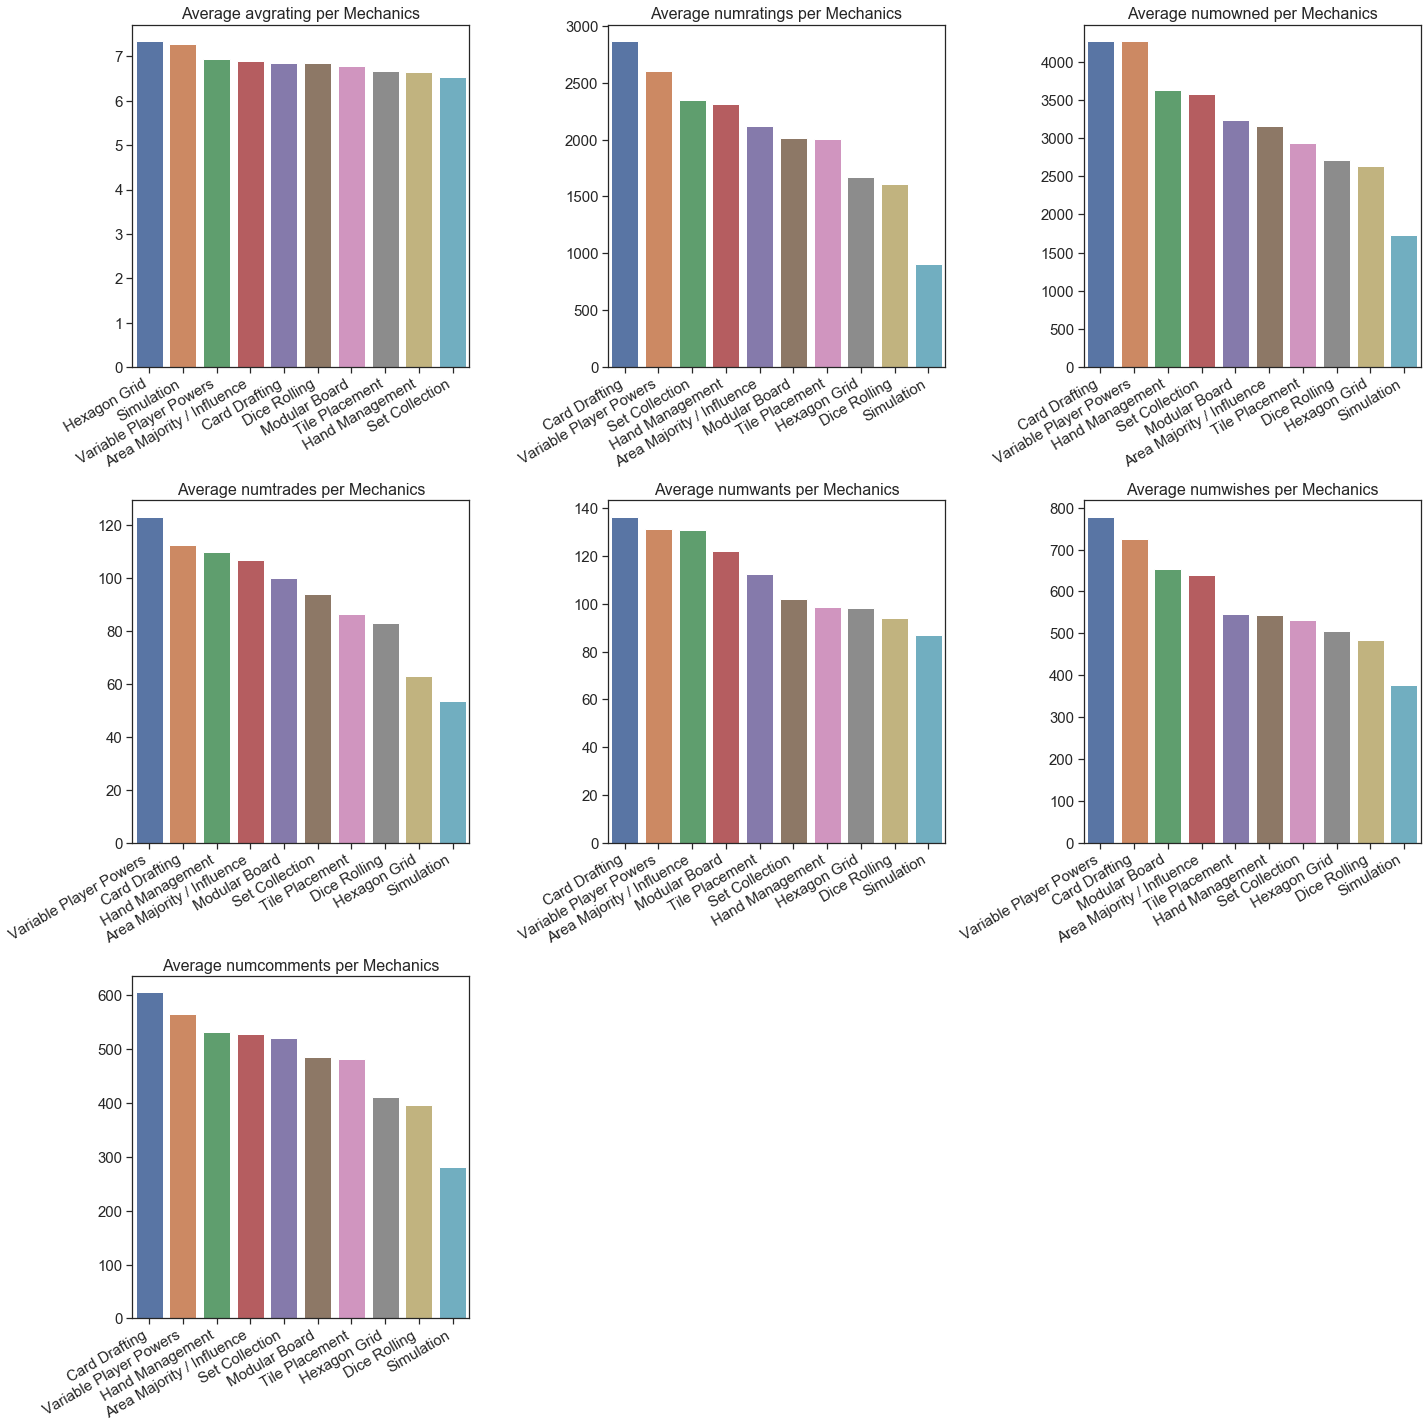

In [15]:
splits, overallstats = summarize_per_attribute(games_mechanic, 100, 1990, 2019, mechanics, popularity_metrics)
fig = plt.figure(figsize=(20,20))
for i, metric in enumerate(popularity_metrics):
    plt.subplot(3,3,i+1)
    plot_avg_stats(overallstats, metric, "Mechanics")
plt.tight_layout()

### 3. Average popularity metrics per designer

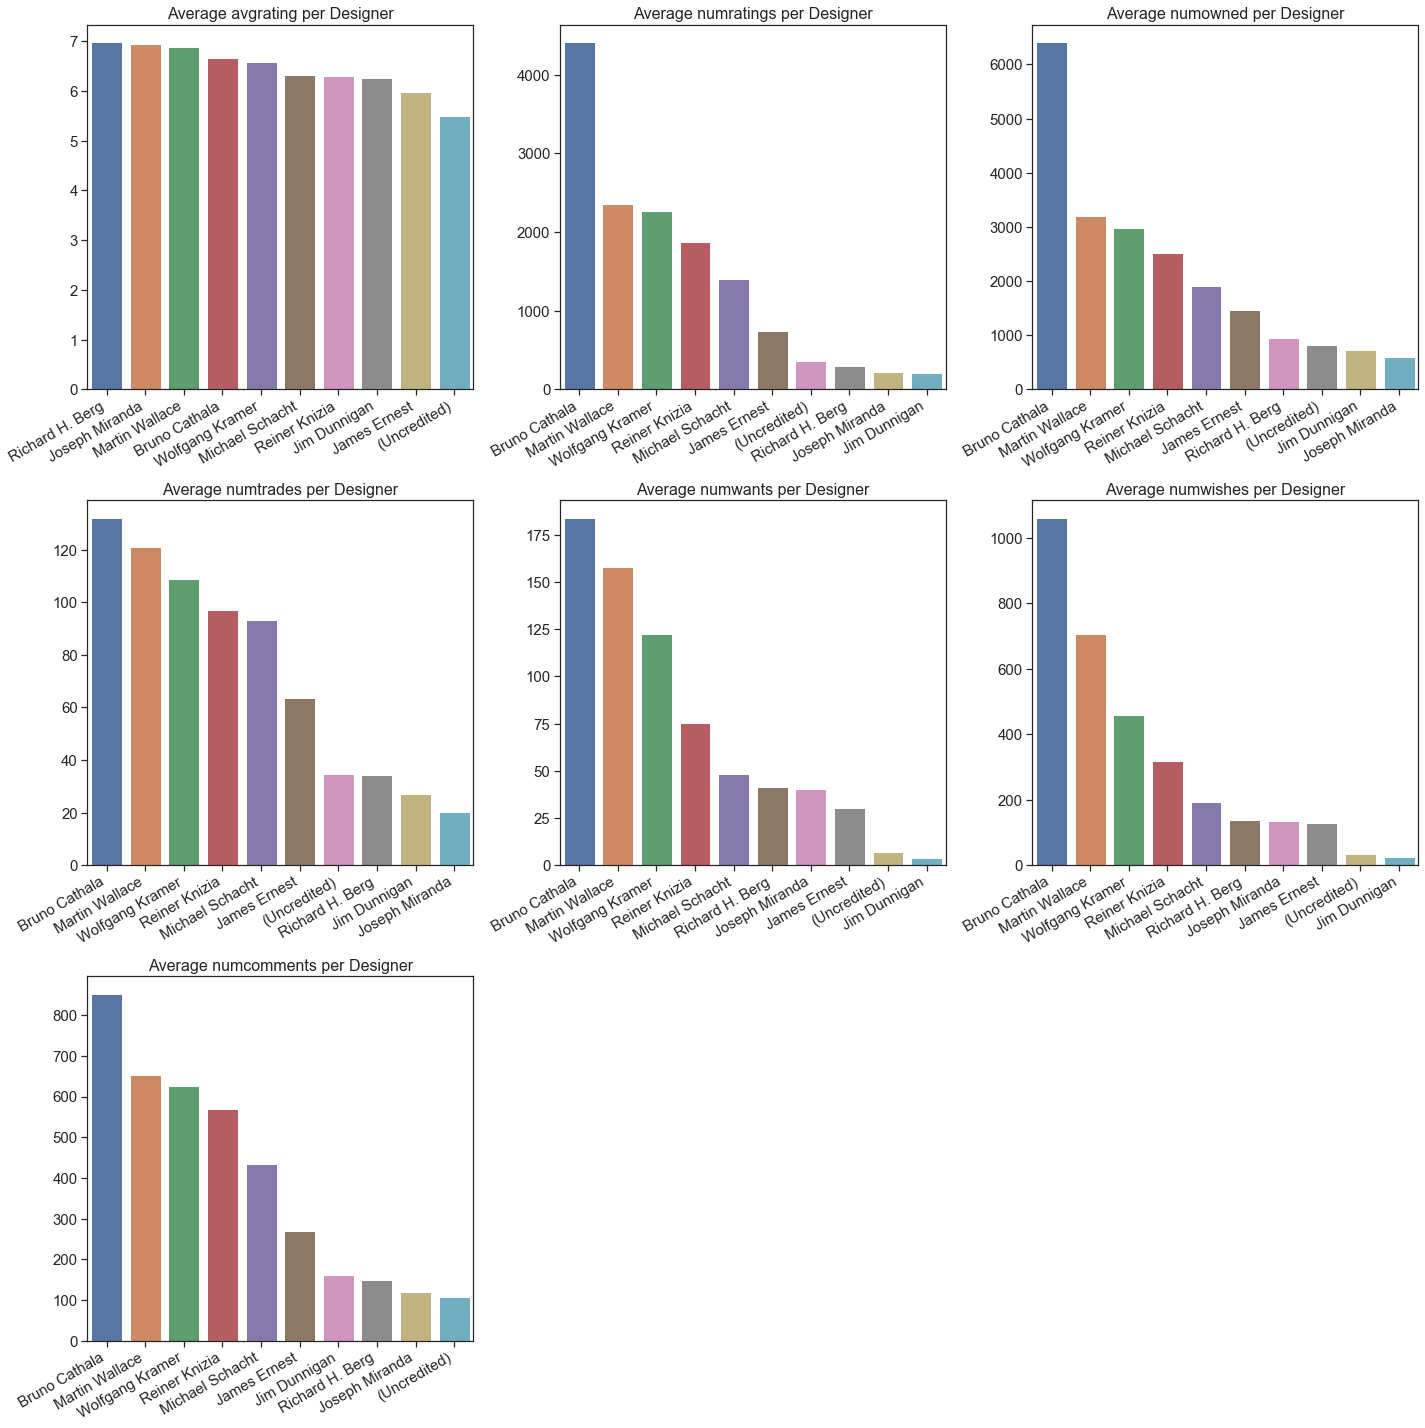

In [17]:
splits, overallstats = summarize_per_attribute(games_designer, 100, 1990, 2019, designers, popularity_metrics)
fig = plt.figure(figsize=(20,20))
for i, metric in enumerate(popularity_metrics):
    plt.subplot(3,3,i+1)
    plot_avg_stats(overallstats, metric, "Designer")
plt.tight_layout()